# 1. Business Problem

- TopBank empresa de serviços bancários. Ela atua principalmente nos países da Europa. 
- Oferecendo produtos financeiros, desde contas bancárias até investimentos, passando por alguns tipos de seguros e produto de investimento.
- Produto principal: conta sem custo para o cliente com vigência de 12 meses, o cliente precisa renovar o contrato dessa conta para continuar utilizando pelos próximos 12 meses.
- Lucro por conda de cliente:
    - 15% do salario estimado, para cliente com salario menor que a media.
    - 20% do salaro estimado, para clientes com salario maior que a media. 

***Problemas***
- A taxa de clientes cancelando suas contas subiu significantemente nos ultimos meses. 

***Objetivo***
- Diminur a taxa de evasão dos clientes, ou seja, impedir que o cliente cancele e não renove por mais 12 meses. 

# 2.0 Solution Planning

## 2.1 Planejamento da Entrega

1. Resposta para o problema:
- Probabilidade do cliente entrar em Churn. 

2. Formato de entrega:
- Tabela do cliente com uma coluna de score

3. Local de entrega: 
- Api envia base de dados. (Streamlit) 

## 2.2 Planejamento do Processo 

1. Passos:
- Analise descritiva

## 2.3 Planejamento da Entrada

1. Fonte de dados: 
- Kagle: https://www.kaggle.com/mervetorkan/churndataset

2. Ferramentas: 
- python 3.8
- jupyter notebook 
- pycharm 
- Heroku 
- Streamlit 


#  3.0 Imports

In [217]:
# data manipulatinon 
import pandas as pd 
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder

#Statystic 
import scipy as misc
from scipy import stats

#text edit 
import inflection

#graph 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image


## 3.1 Helper Functions 

In [218]:
sns.set_theme()
sns.set(rc={'figure.figsize':(21.7,18.27)})

def cramer_v(x, y):
    
    # generate confusion matrix, contigency table
    conf_matrix = pd.crosstab(x, y).values
    n = conf_matrix.sum()
    r,k = conf_matrix.shape
    
    chi2 = stats.chi2_contingency(conf_matrix)[0]
    
    #bias corretion
    
    # chi2 correction 
    chi2_bias = max(0, chi2 - (k-1)*(r-1)/(n-1)) 
    
    # chi2 correction
    k_bias = k - (k-1)**2/(n-1)
    
    # chi2 correction
    r_bias = r - (r-1)**2/(n-1)
    
    # calculate cramer v 
    return np.sqrt((chi2_bias/n)/min(k_bias-1, r_bias-1))
    

## 3.2 Loading Data

In [219]:
df_churn_raw = pd.read_csv('../data/raw/churn.csv', low_memory=False)

# 4.0 Data Description

##  4.1 Rename Columns 

In [220]:
df1 = df_churn_raw.copy()

In [221]:
cols_old = df1.columns

snake_case = lambda x : inflection.underscore(x)
cols_new = list(map(snake_case, cols_old))

#renomeando colunas
df1.columns = cols_new

##  4.2 Data Dimensions 

In [222]:
print('- Number of rows {}' .format(df1.shape[0]))
print('- Number of cols {}' .format(df1.shape[1]))

- Number of rows 10000
- Number of cols 14


## 4.3 Data Type  

In [223]:
df1.dtypes

row_number            int64
customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

##  4.4 Check NA 

In [224]:
df1.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 4.5 Descriptive Statistical

In [225]:
df_num_attributes = df1[['row_number', 'tenure','credit_score', 'age', 'balance', 'estimated_salary']]
df_cat_attributes = df1[['geography', 'gender', 'num_of_products', 
                         'has_cr_card', 'is_active_member', 'exited']]

### 4.5.1  Numerical Attributes 

In [226]:
df_num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
row_number,10000.0,5000.500000,2886.895680,1.00,2500.75,5000.500,7500.2500,10000.00
tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
credit_score,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
estimated_salary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48


In [227]:
disp_kurtosis = df_num_attributes.apply(lambda x : x.kurtosis())
disp_skew = df_num_attributes.apply(lambda x : x.skew())

In [228]:
df_disp = pd.DataFrame([disp_kurtosis, disp_skew]).T
df_disp.columns = ['kurtosis', 'skew']
df_disp

,kurtosis,skew
row_number,-1.200000,0.000000
tenure,-1.165225,0.010991
credit_score,-0.425726,-0.071607
age,1.395347,1.011320
balance,-1.489412,-0.141109
estimated_salary,-1.181518,0.002085


### 4.5.2 Categorical Attributes 

In [229]:
df_cat_attributes.nunique()

geography           3
gender              2
num_of_products     4
has_cr_card         2
is_active_member    2
exited              2
dtype: int64

In [230]:
# Percentage of clients in each country
geo_percentage = df_cat_attributes['geography'].value_counts(normalize=True)*100
geo_percentage

France     50.14
Germany    25.09
Spain      24.77
Name: geography, dtype: float64

In [231]:
# Percentage of clients in each gender
gender_percentage = df_cat_attributes['gender'].value_counts(normalize=True)*100
gender_percentage

Male      54.57
Female    45.43
Name: gender, dtype: float64

<AxesSubplot:xlabel='exited', ylabel='credit_score'>

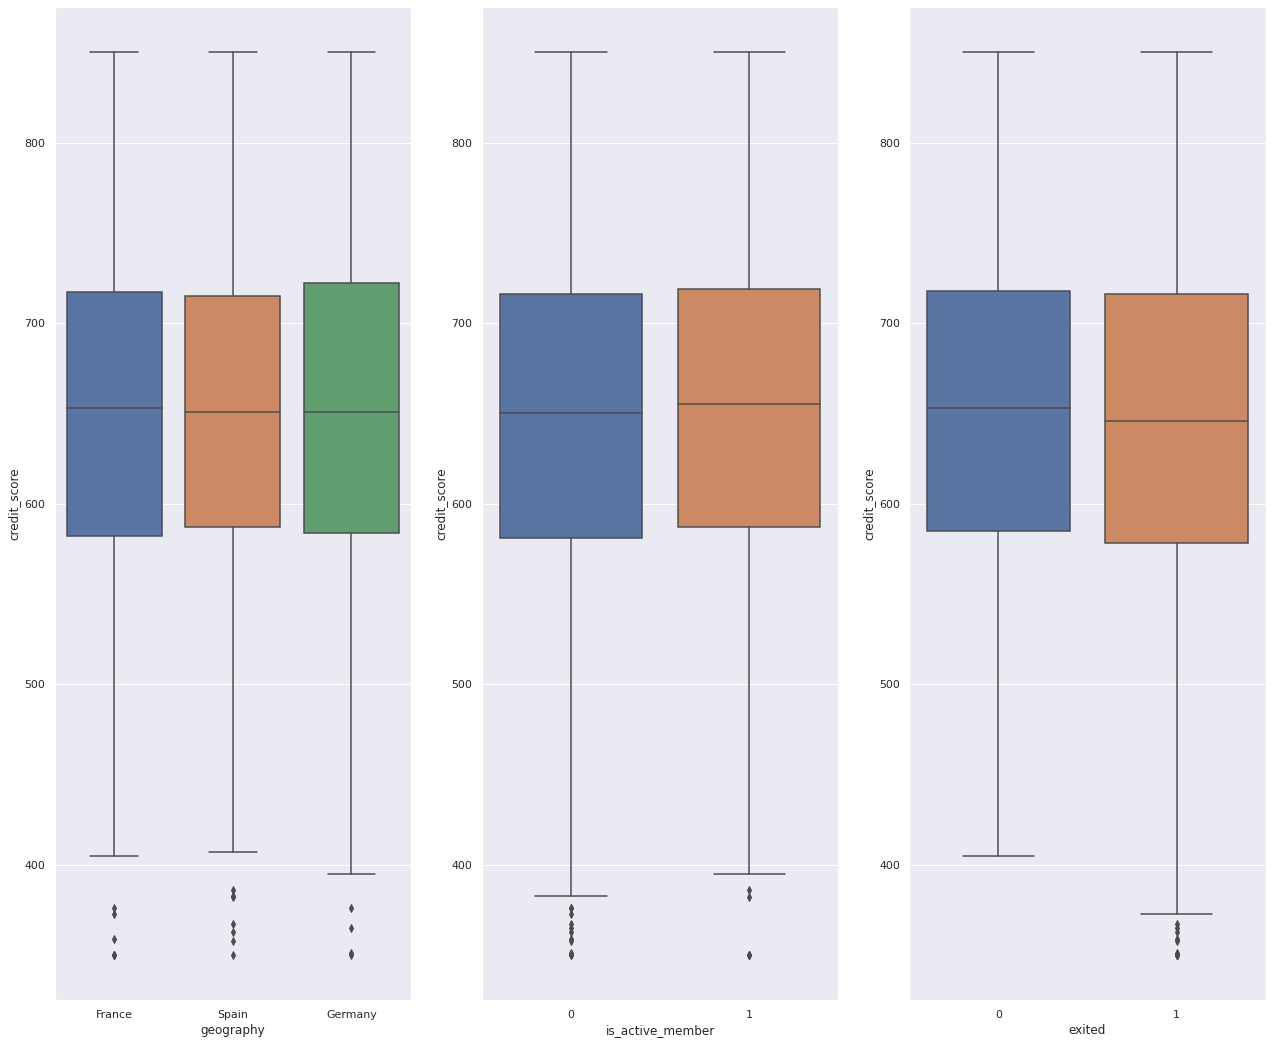

In [232]:
plt.subplot(1,3,1) 
sns.boxplot(x = 'geography', y = 'credit_score', data=df1)

plt.subplot(1,3,2)
sns.boxplot(x = 'is_active_member', y = 'credit_score', data=df1)

plt.subplot(1,3,3)
sns.boxplot(x = 'exited', y = 'credit_score', data=df1)

In [233]:
df_cat_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
num_of_products,10000.0,1.5302,0.581654,1.0,1.0,1.0,2.0,4.0
has_cr_card,10000.0,0.7055,0.455840,0.0,0.0,1.0,1.0,1.0
is_active_member,10000.0,0.5151,0.499797,0.0,0.0,1.0,1.0,1.0
exited,10000.0,0.2037,0.402769,0.0,0.0,0.0,0.0,1.0


# 5.0 Feature Engineering 

In [234]:
df2 = df1.copy()

## 5.1 Hypotheses Mental Map

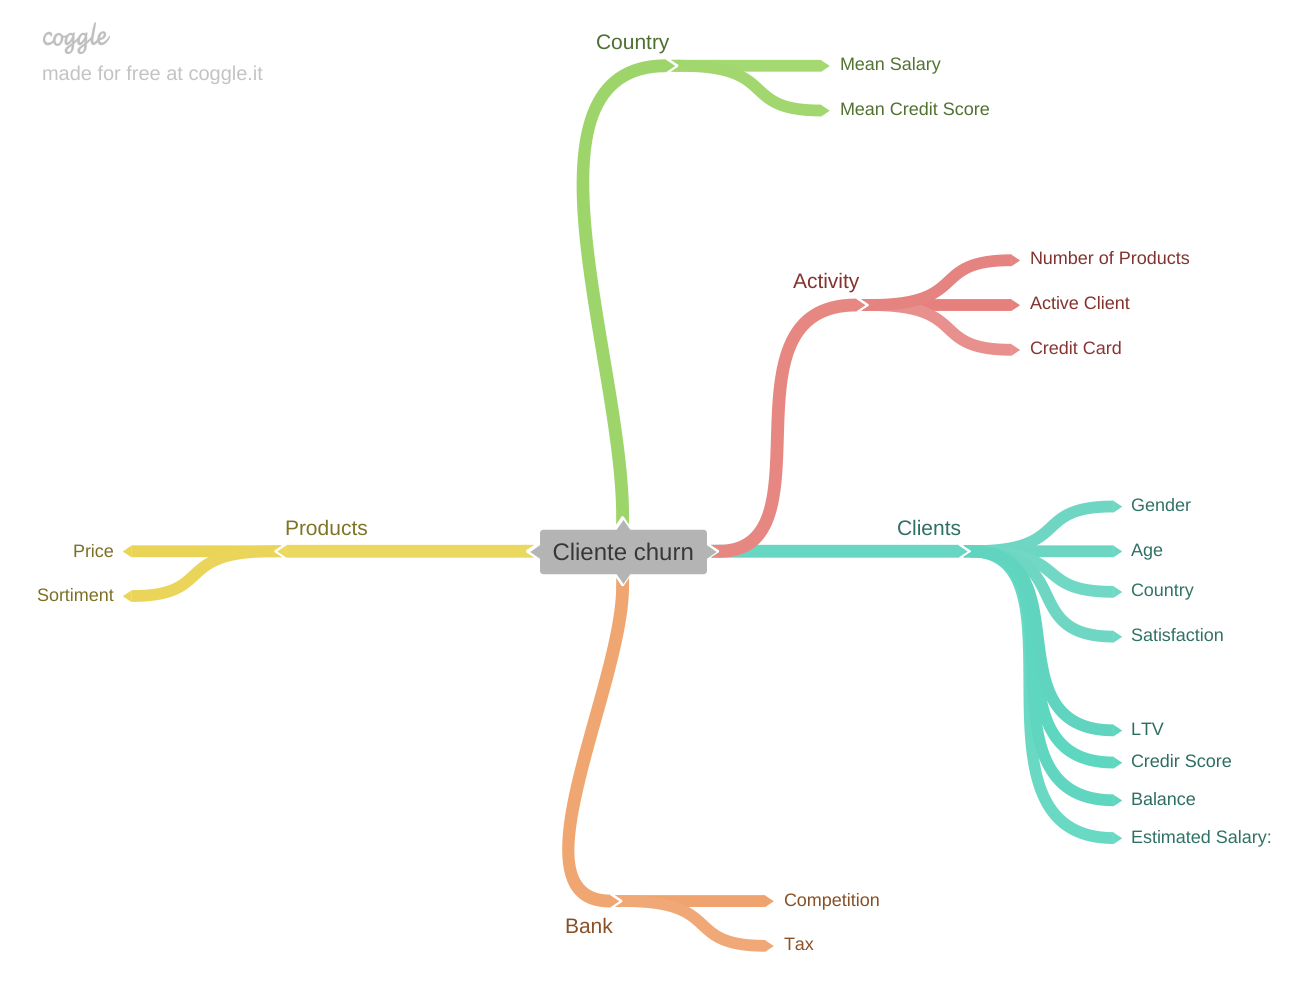

In [235]:
Image('../img/Cliente_churn.png')

## 5.1 Hypotheses

### 5.1.1 Client Hypotheses 

1. Cliente com idade abaixo de 32 anos sao 25% mais em Churn.
2. Clientes com salario abaixo de 1000 Churn sao 50% mais em Churn.
3. Clientes com Saldo maior que a media estão 30% menos presentes em churn.
4. Clientes com satisfação ruim estão 30% mais presentes em churn 
5. Clientes que moram na Franca tem churn 15% maior 


### 5.1.2 Country Hypotheses 

1. Clientes com salario menor que a media do pais tem Churn 10% maior. 
2. Clientes com Credit Score menor que a media do pais tem Churn 10% maior. 
3. Clientes com Saldo maior que a media do pais tem Churn é 20% menor. 

### 5.1.3 Activity Hypoteses 

1. Churn é 10% menor para clientes que possuen cartão. 
2. Churn é 30% menor para cliente ativos. 
3. Churn é 25% maior para clientes com apenas um produto comprado. 

### 5.1.4 Products Hypoteses 

1. Churn é 40% maior para taxa maior que a taxa media da competicao

## 5.2 Hypoteses List 

1. Cliente com idade abaixo de 32 anos sao 25% mais em Churn.
2. Clientes com salario abaixo de 1000 Churn sao 50% mais em Churn.
3. Clientes com Saldo maior que a media estão 30% menos presentes em churn.
4. Clientes que moram na Franca tem churn 15% maior 
5. Clientes com salario menor que a media do pais tem Churn 10% maior. 
6. Clientes com Credit Score menor que a media do pais tem Churn 10% maior. 
7. Clientes com Saldo maior que a media do pais tem Churn é 20% menor. 
8. Churn é 10% menor para clientes que possuen cartão. 
9. Churn é 30% menor para cliente ativos. 
10. Churn é 25% maior para clientes com apenas um produto comprado. 

## 5.3  Feature Engineering 

In [236]:
# creating geography median salary 
df2['geo_median_salary'] = df2.groupby('geography')['estimated_salary'].transform('median')

# creating geography median Credit Score 
df2['geo_median_cred'] = df2.groupby('geography')['credit_score'].transform('median')

# creating geography median balance
df2['geo_median_balc'] = df2.groupby('geography')['balance'].transform('median')

In [237]:
df2.head().T

,0,1,2,3,4
row_number,1,2,3,4,5
customer_id,15634602,15647311,15619304,15701354,15737888
surname,Hargrave,Hill,Onio,Boni,Mitchell
credit_score,619,608,502,699,850
geography,France,Spain,France,France,Spain
gender,Female,Female,Female,Female,Female
age,42,41,42,39,43
tenure,2,1,8,1,2
balance,0.0,83807.86,159660.8,0.0,125510.82
num_of_products,1,1,3,2,1


# 6.0 Variable Filtering

In [238]:
df3 = df2.copy()

## 6.1 Columns Select 

In [239]:
cols_drop = ['surname','customer_id']
df3 = df3.drop(cols_drop, axis=1)

In [240]:
df3.T

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
row_number,1,2,3,4,5,6,7,8,9,10,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
credit_score,619,608,502,699,850,645,822,376,501,684,...,714,597,726,644,800,771,516,709,772,792
geography,France,Spain,France,France,Spain,Spain,France,Germany,France,France,...,Germany,France,Spain,France,France,France,France,France,Germany,France
gender,Female,Female,Female,Female,Female,Male,Male,Female,Male,Male,...,Male,Female,Male,Male,Female,Male,Male,Female,Male,Female
age,42,41,42,39,43,44,50,29,44,27,...,33,53,36,28,29,39,35,36,42,28
tenure,2,1,8,1,2,8,7,4,4,2,...,3,4,2,7,2,5,10,7,3,4
balance,0.0,83807.86,159660.8,0.0,125510.82,113755.78,0.0,115046.74,142051.07,134603.88,...,35016.6,88381.21,0.0,155060.41,0.0,0.0,57369.61,0.0,75075.31,130142.79
num_of_products,1,1,3,2,1,2,2,4,2,1,...,1,1,1,1,2,2,1,1,2,1
has_cr_card,1,0,1,0,1,1,1,1,0,1,...,1,1,1,1,0,1,1,0,1,1
is_active_member,1,1,0,0,1,0,1,0,1,1,...,0,0,0,0,0,0,1,1,0,0


# 7.0 Exploratory Data Analysis 

In [241]:
df4 = df3.copy()
df_num_attributes = df4[['tenure','credit_score', 'age', 'balance', 'estimated_salary',
                         'geo_median_salary', 'geo_median_cred', 'geo_median_balc','num_of_products']]
df_cat_attributes = df4[['geography', 'gender', 'has_cr_card', 'is_active_member', 'exited',]]

## 7.1 Univariate

### 7.1.1 Response Attribute 

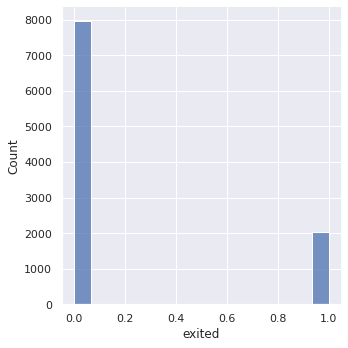

In [242]:
sns.displot(x = 'exited', data = df4);

### 7.1.2 Numerical Attributes 

In [243]:
df_num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
credit_score,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
estimated_salary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
geo_median_salary,10000.0,100162.652554,1339.072505,99132.31,99132.31,99132.310,102397.2200,102397.22
geo_median_cred,10000.0,652.002800,1.000046,651.00,651.00,653.000,653.0000,653.00
geo_median_balc,10000.0,76482.948678,25014.955033,61710.44,62153.50,62153.500,119703.1000,119703.10
num_of_products,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00


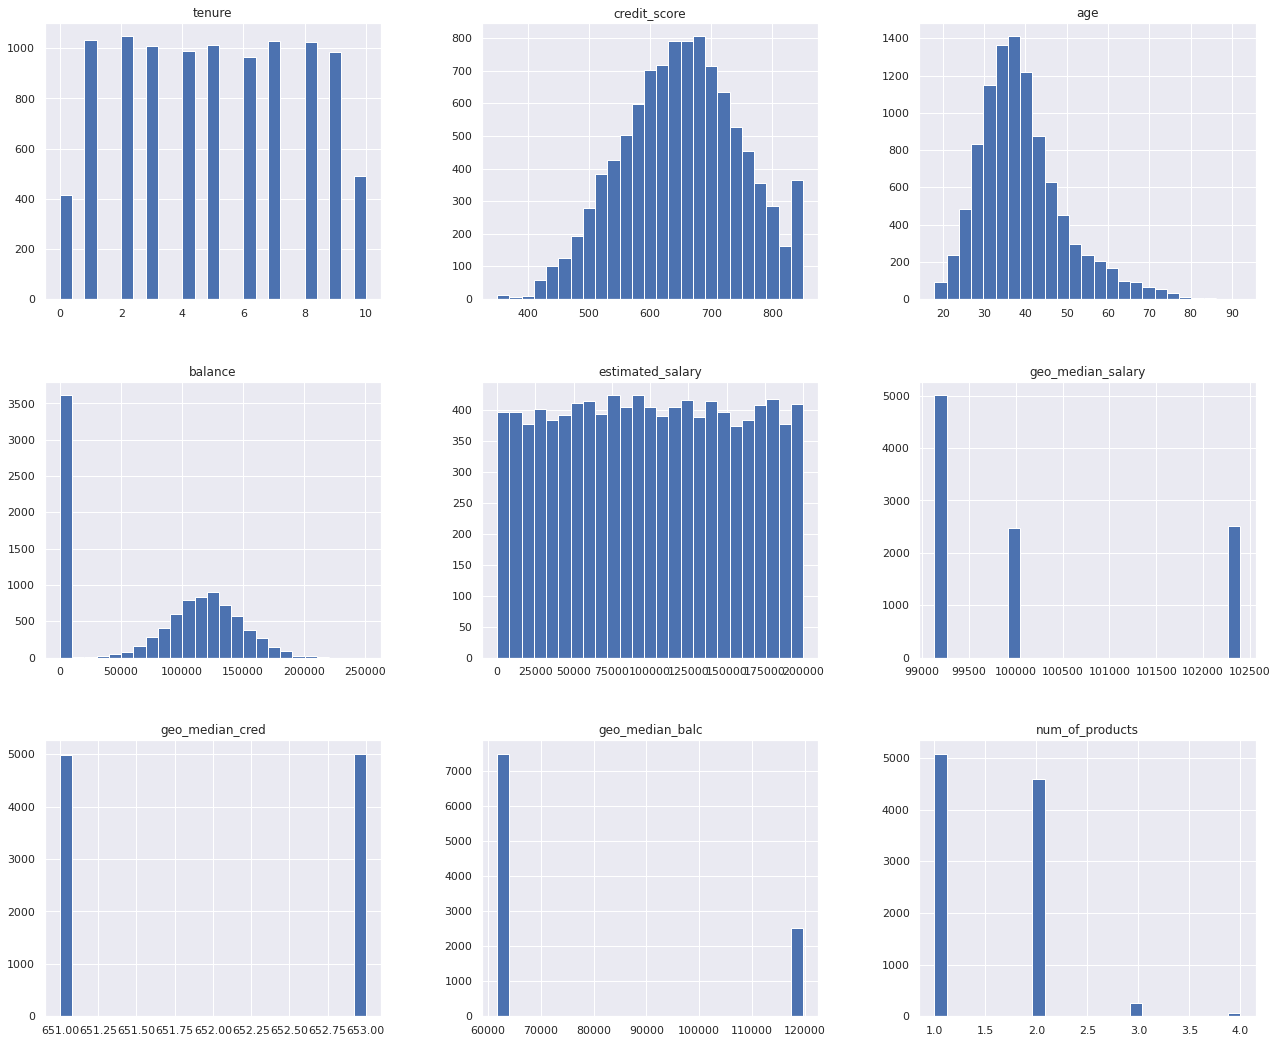

In [244]:
df_num_attributes.hist(bins=25);

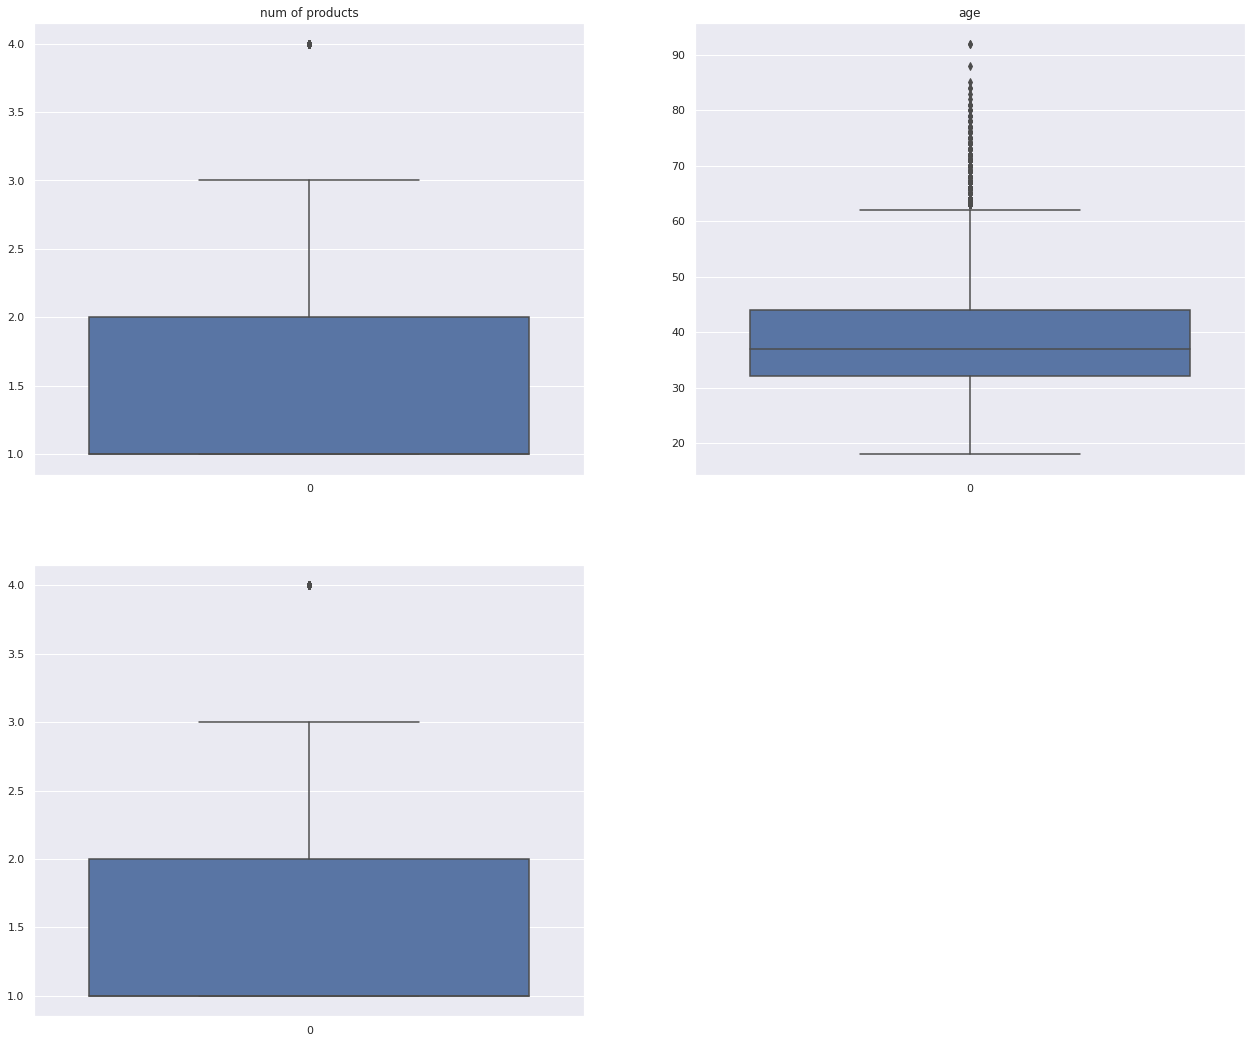

In [245]:
plt.subplot(2,2,1)
sns.boxplot(data = df_num_attributes['num_of_products']).set_title('num of products');

plt.subplot(2,2,2)
sns.boxplot(data = df_num_attributes['age']).set_title('age');

plt.subplot(2,2,3)
sns.boxplot(data = df_num_attributes['num_of_products']);

### 7.1.3 Categorical Attributes  

#### Geography


In [246]:
geo_precentage = df4['geography'].value_counts(normalize=True)*100

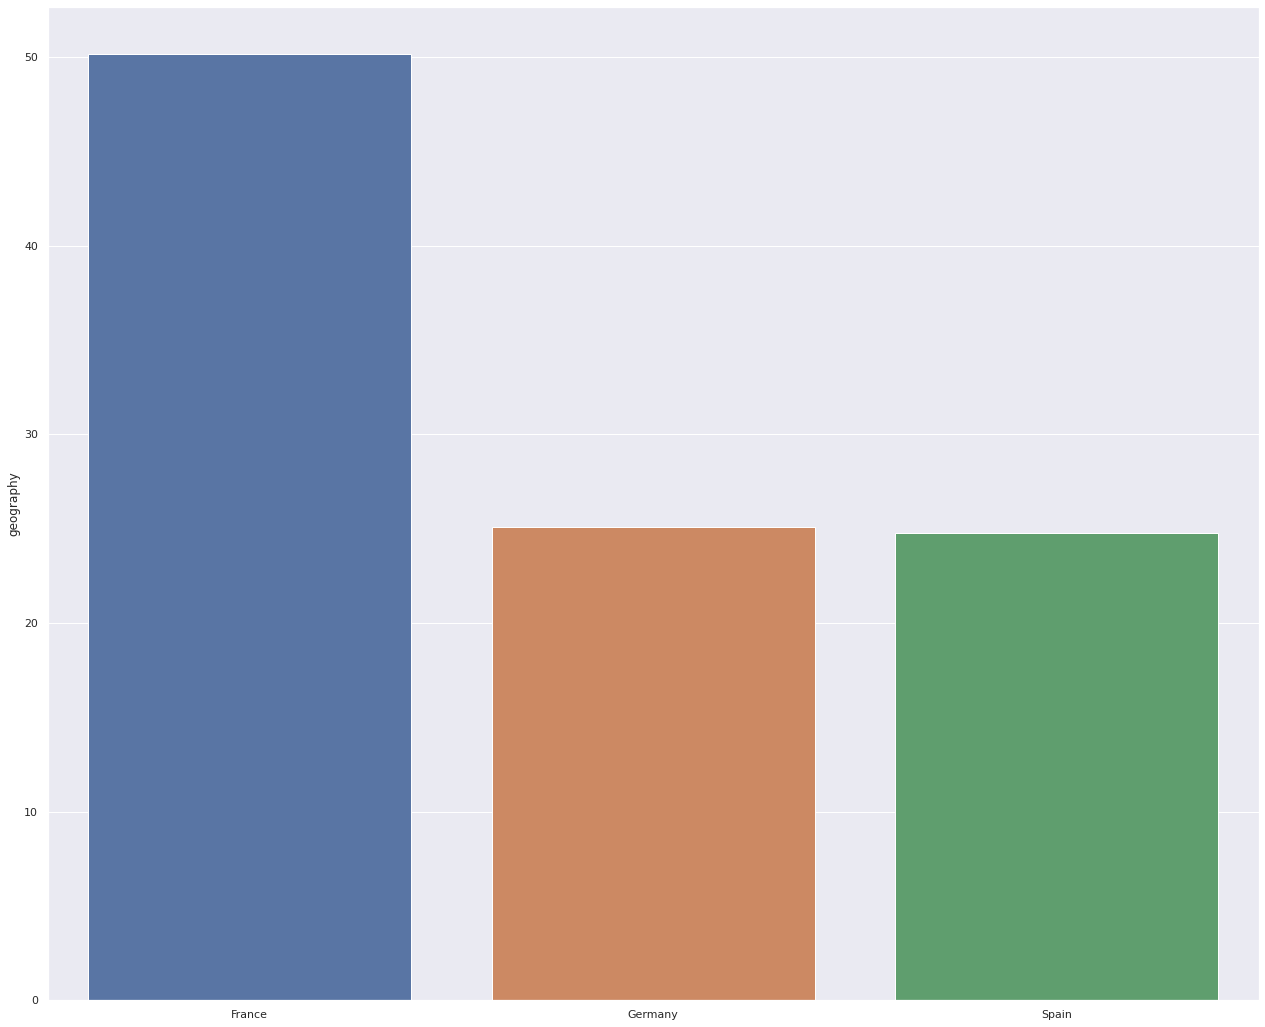

In [247]:
sns.barplot(x = geo_percentage.index , y = geo_percentage);

#### Credit Card 

In [248]:
cr_precentage = df4['has_cr_card'].value_counts(normalize=True)*100

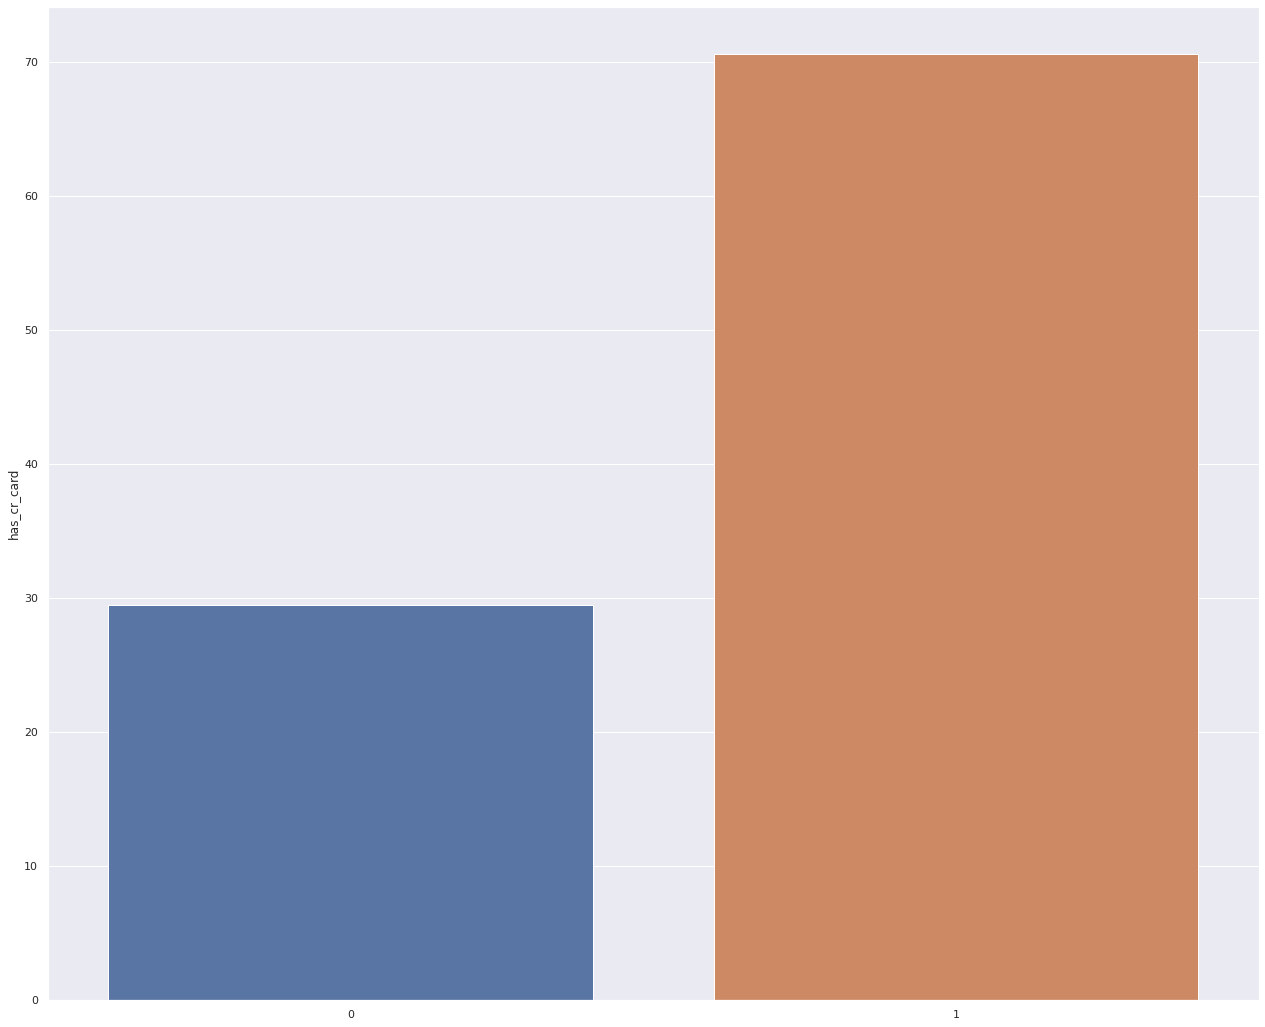

In [249]:
sns.barplot(x = cr_precentage.index , y = cr_precentage);

#### Activit  

In [250]:
actv_precentage = df4['is_active_member'].value_counts(normalize=True)*100

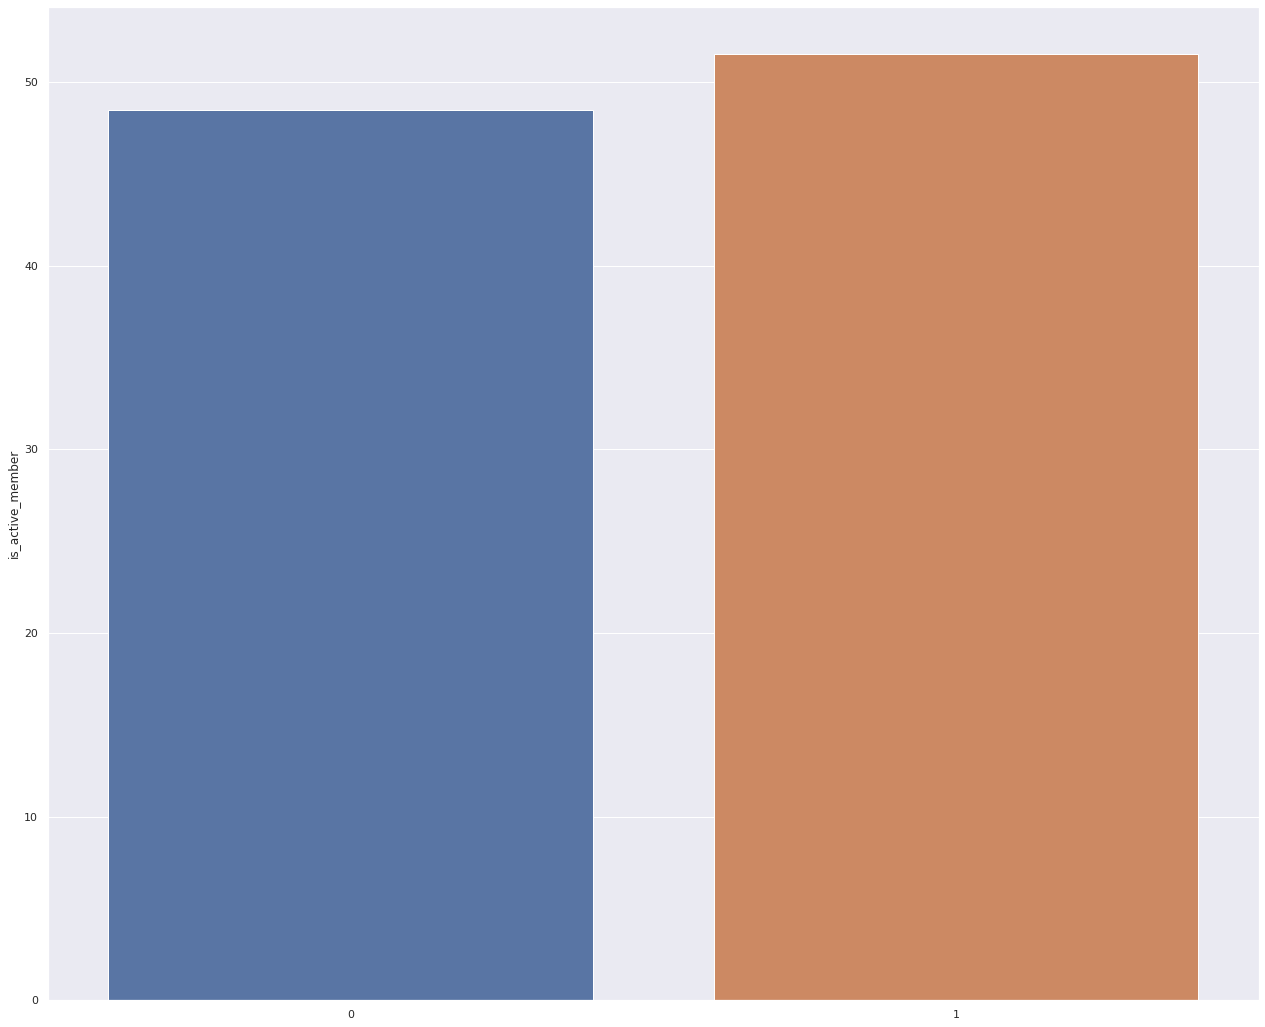

In [251]:
sns.barplot(x = actv_precentage.index , y = actv_precentage);

In [252]:
actv_precentage

1    51.51
0    48.49
Name: is_active_member, dtype: float64

- 50% dos clientes residem na franca, ja Alemanha e Franca possuem 25% dos clientes. 
- 70% dos clientes possuem cartao de credito. 
- 51% dos clientes realizaram alguma atividade nos ultimos 12 meses. 

## 7.2 Bivariate 

### **H1.** Cliente com idade abaixo de 38 anos sao 25% mais em Churn.
**FALSO** Clientes com idade acima de 38 anos estão 50% mais presentes em churn, mesmos sendo a menor populacao

In [253]:
df_age = df4[['age', 'exited','row_number']].copy()

In [254]:
df_age['above_below'] = df_age['age'].apply(lambda x : 'below' if x <= 38 else 'above')

In [255]:
aux5 = df_age[['age', 'exited','row_number']].groupby(['age', 'exited']).count().reset_index()

In [256]:
aux1 = df_age[df_age['exited']==1].groupby('age')['exited'].count().reset_index()

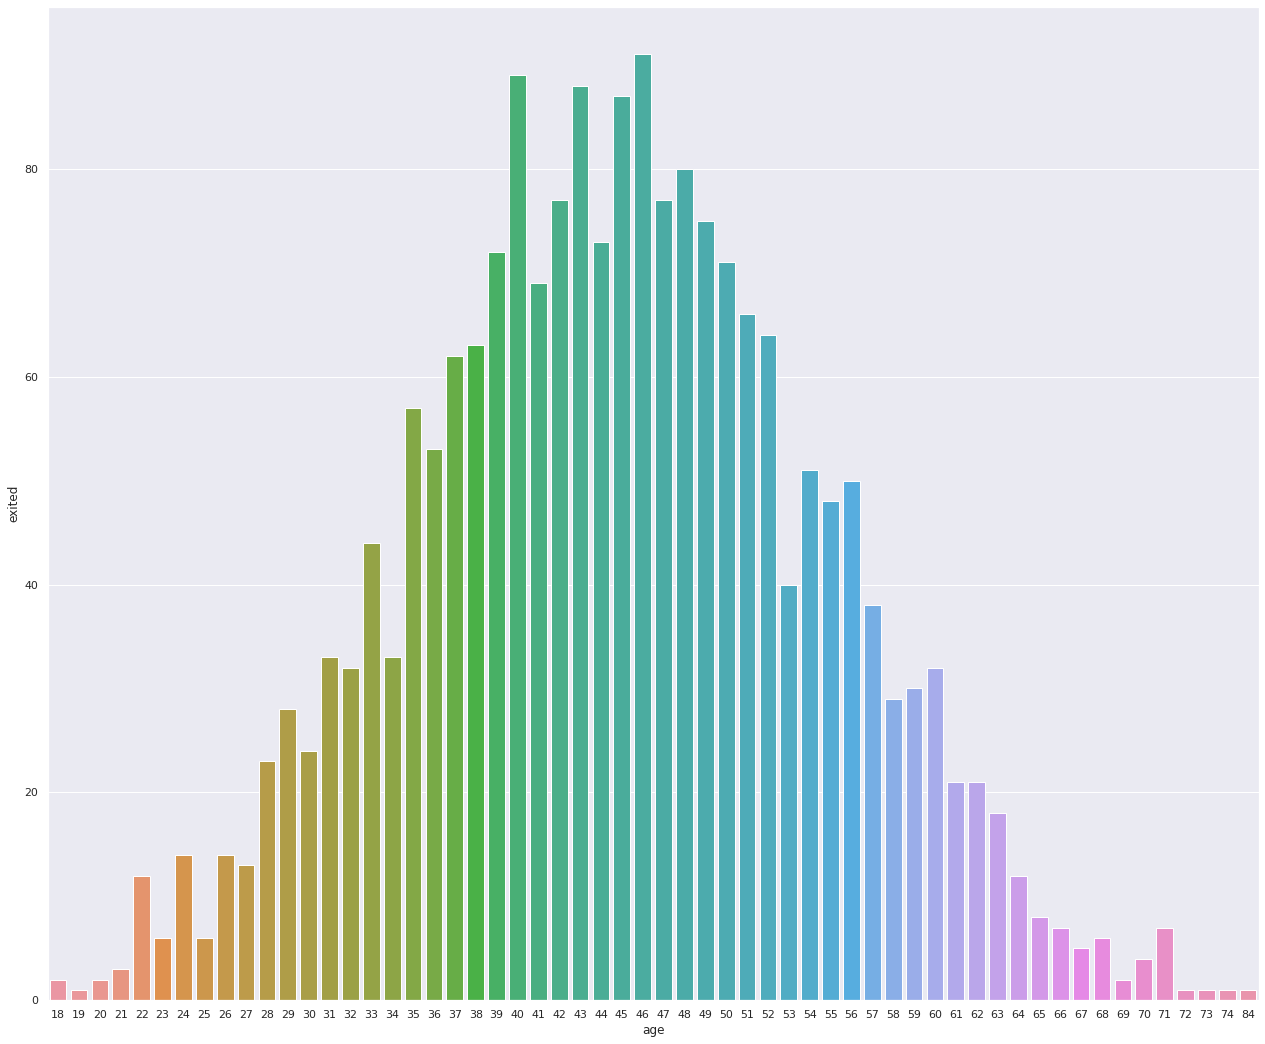

In [257]:
sns.barplot(x = 'age', y = 'exited',data = aux1);

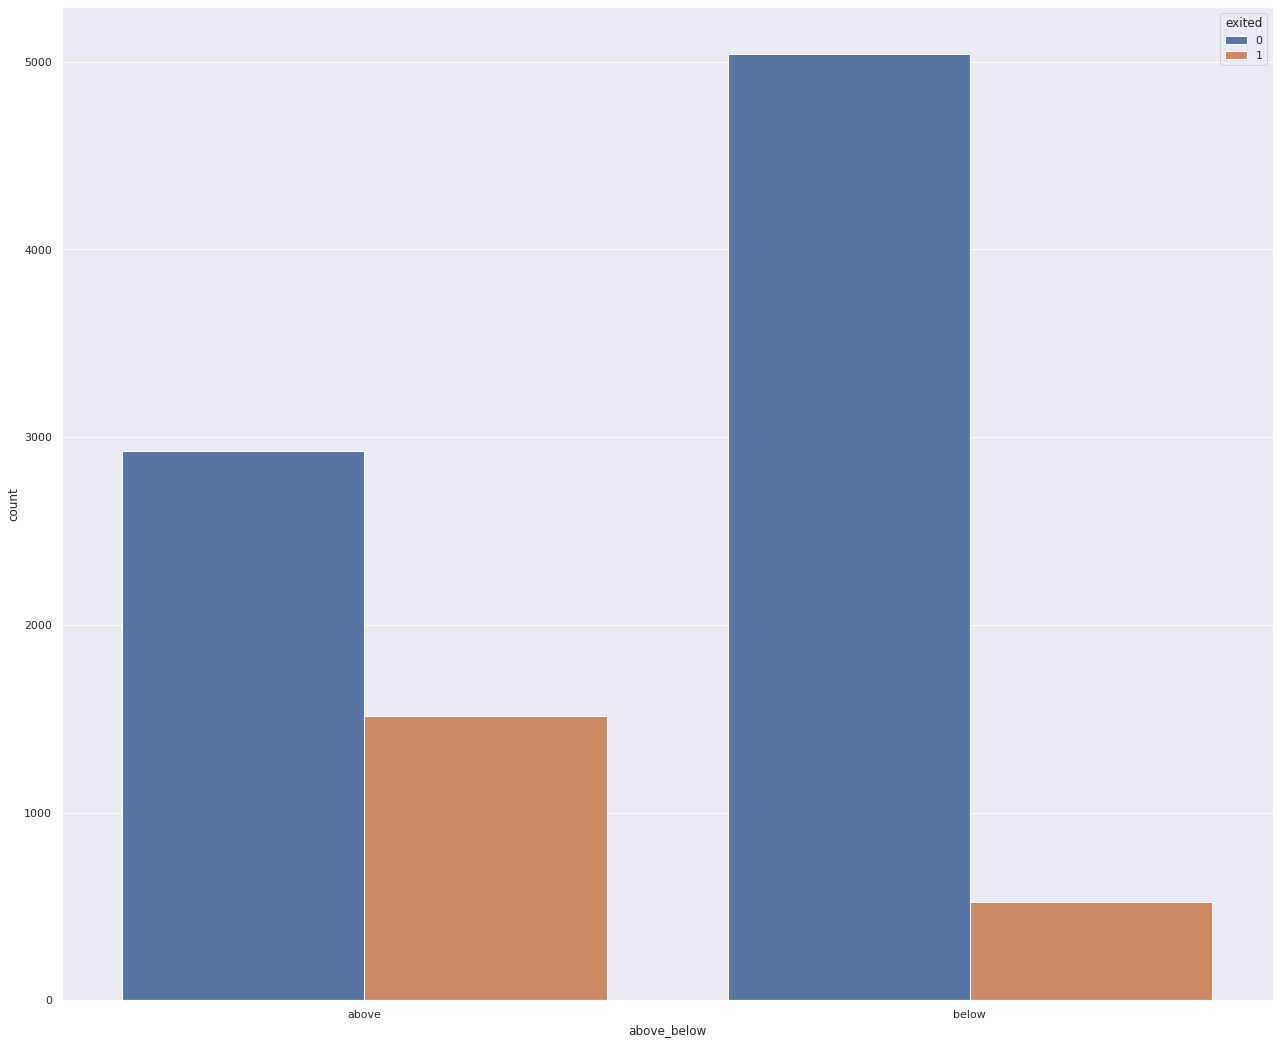

In [258]:
aux2 = df_age.groupby('exited')['above_below'].value_counts().to_frame(name='count').reset_index()
sns.countplot(x = 'above_below', hue = 'exited', data = df_age);

In [259]:
df_age.groupby('exited')['above_below'].value_counts(normalize = True)

exited  above_below
0       below          0.632802
        above          0.367198
1       above          0.742268
        below          0.257732
Name: above_below, dtype: float64

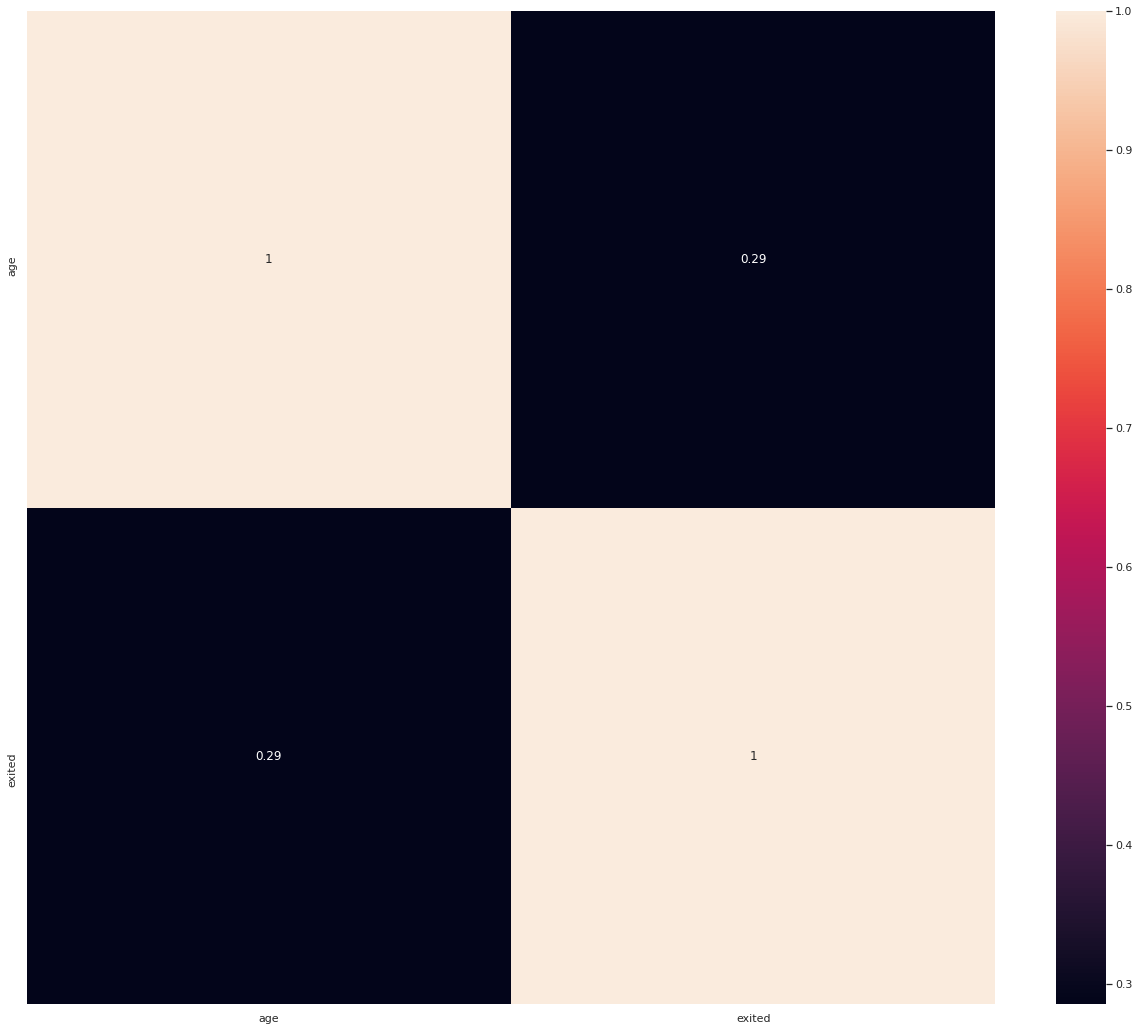

In [260]:
sns.heatmap(df_age[['age','exited']].corr(method = 'pearson'), annot = True);

- Como visto, 5564(55%) clientes possuem idade iferior ou igual a 38 anos e 4446(44%) possuem idade superior a 38 anos
- Aproximadamente 1512(75%) dos clientes em Churn tem idade maior que 38 anos e apenas 525(25%) tem idade inferior, assim sendo um diferença aprixomade de 50%. 
- Aproximadamente 2924(36%) dos clientes que não estão em Churn tem idade maior que 38 anos e apenas 5039(63%) tem idade inferior, assim sendo um diferença aprixomade de 50%. 

### **H3.** Clientes com Saldo maior que a media estão 30% menos presentes em churn.
**FALSE** Clientes com Saldo maior que a media estao 40% mais presentes em Churn que clientes com saldo menor. 

In [261]:
df_balance = df4[['balance', 'exited']].copy().reset_index()

In [262]:
df_balance['h_balance'] = df_balance['balance'].apply(lambda x : 'above' if x > df_balance['balance'].mean() 
                                                      else 'below' )

In [263]:
df_balance_ext = df_balance.groupby('exited')['h_balance'].value_counts(normalize = True).to_frame(name ='count').reset_index()

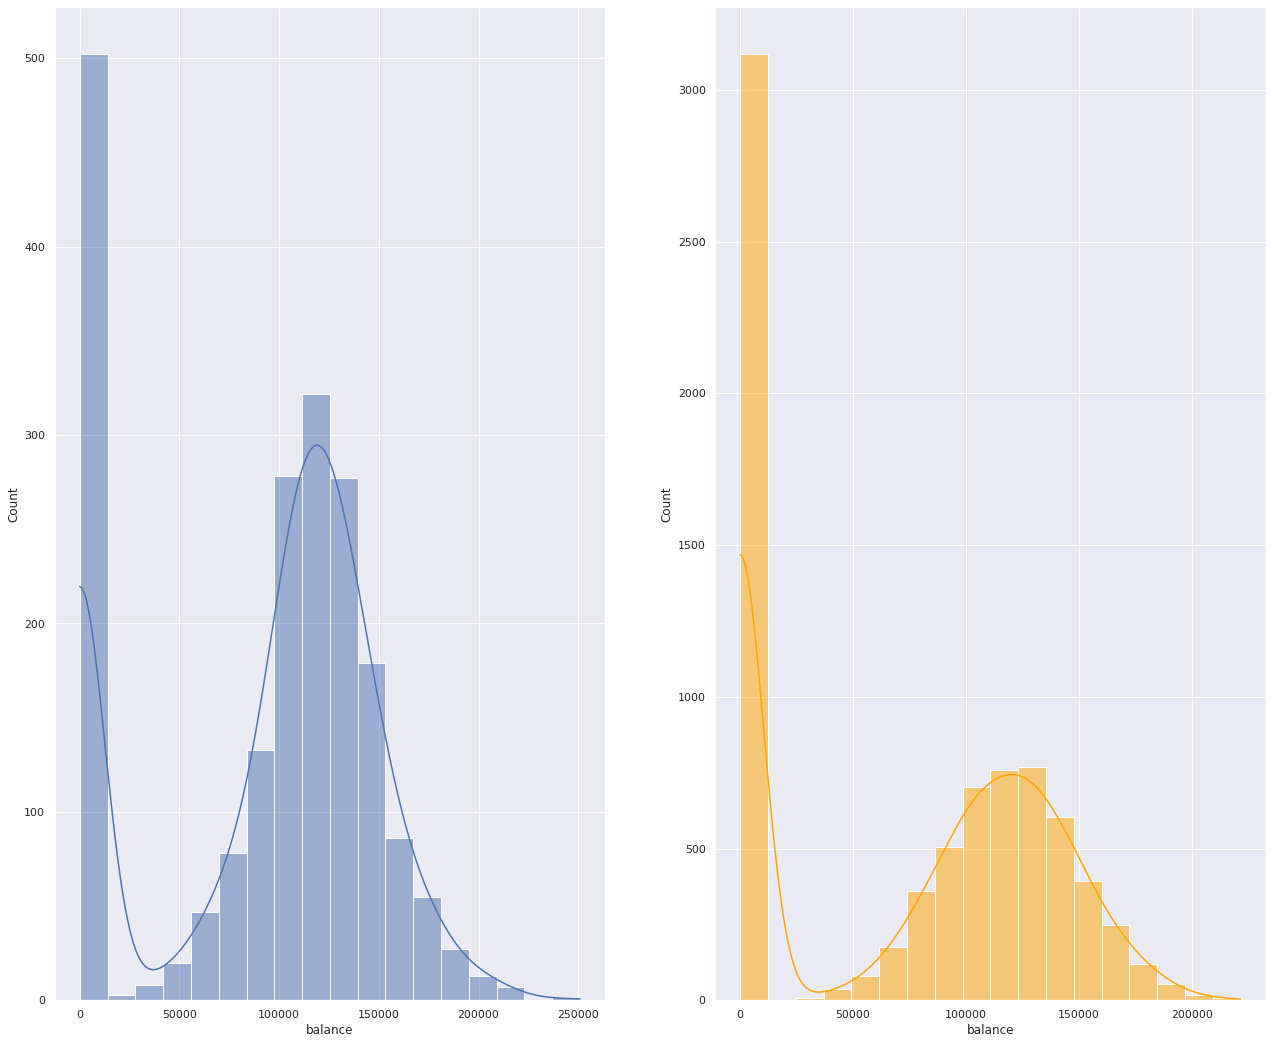

In [264]:
plt.subplot(1,2,1)
sns.histplot(x = 'balance', data = df_balance[df_balance['exited']==1],kde=True); 
plt.subplot(1,2,2)
sns.histplot(x = 'balance', data = df_balance[df_balance['exited']==0], color='orange',kde = True ); 


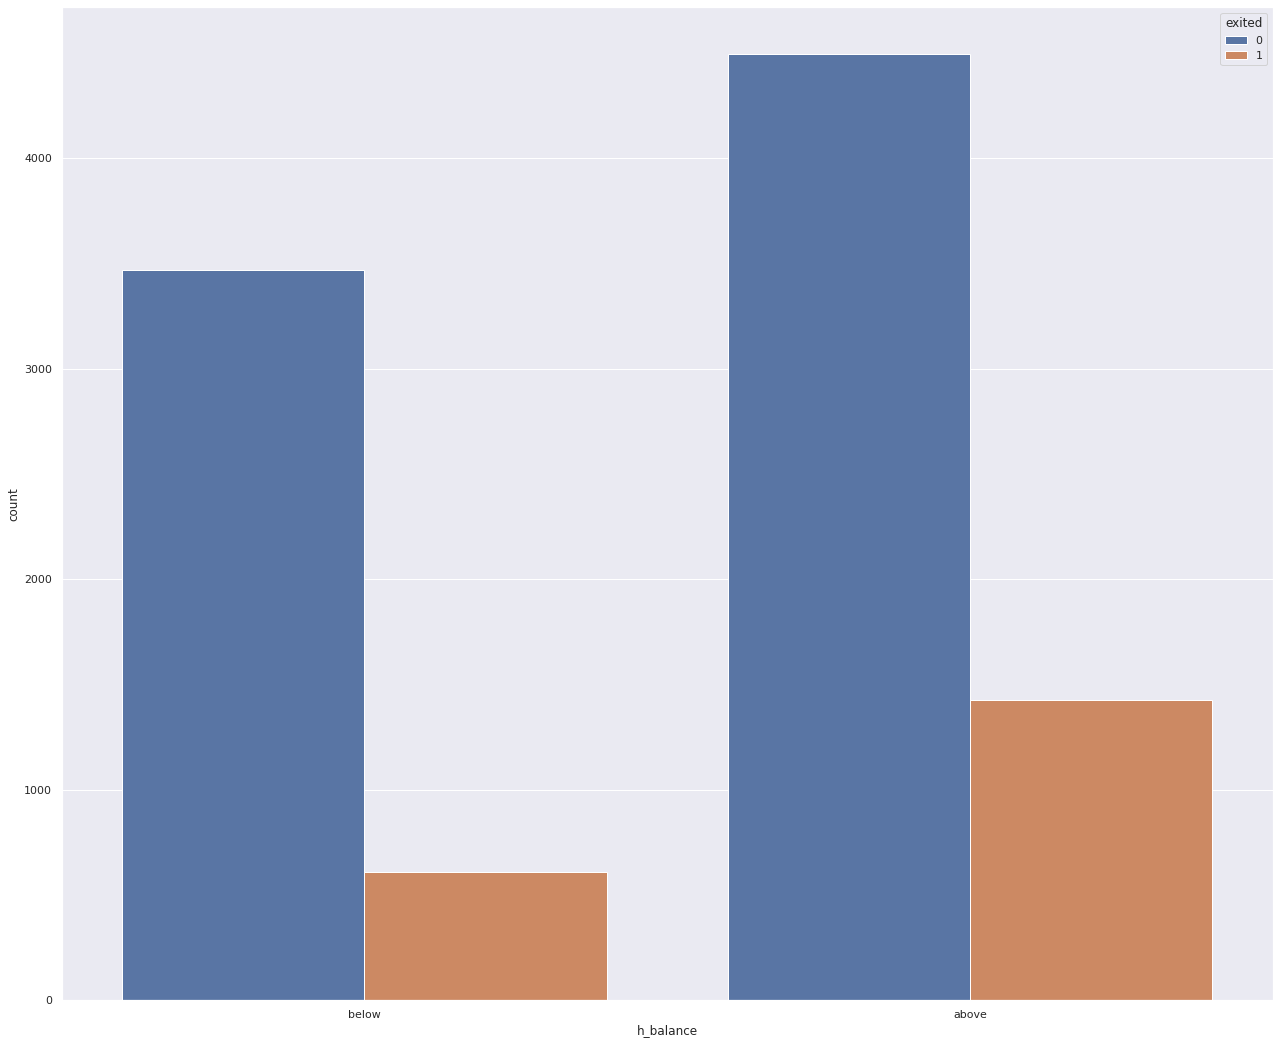

In [265]:
sns.countplot(x = 'h_balance', hue = 'exited', data = df_balance);

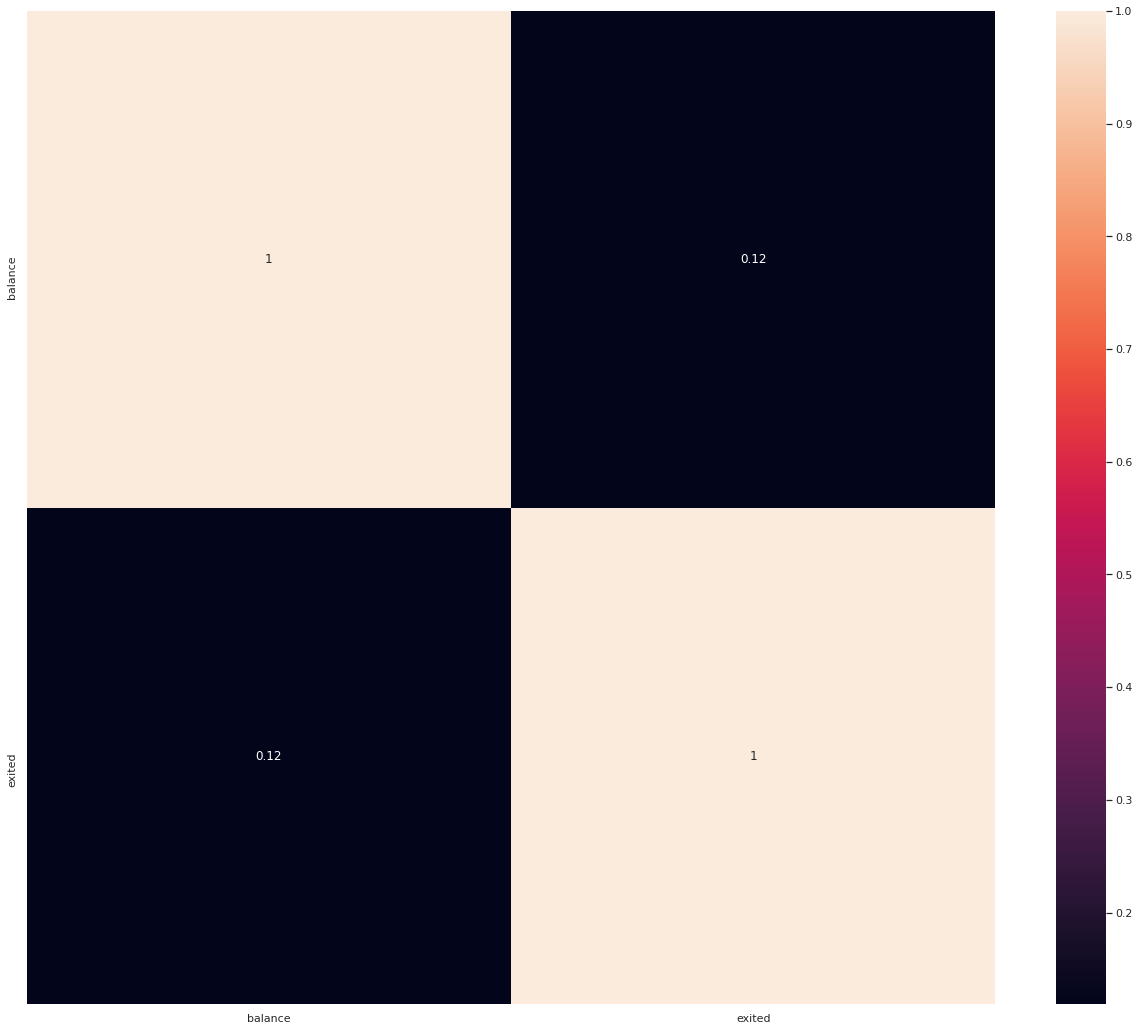

In [266]:
sns.heatmap(df_balance[['balance','exited']].corr(method = 'pearson'), annot = True);

- Como observado no Churn, cerca de 1426(70%) clientes possuem saldo maior que a media, quanto apenas 611(30%) tem saldo menor. 
- Como observado nos clientes que nao estao em Churn, clientes que tem saldo maior que a media mesmo sendo maior numero em Churn tambem é a maiora nem não Churn sendo 4493(55%) , quanto os com saldo menor sao 3470(45%) 

### H4. Franca tem churn 15% maior que outros paises. 
**FALSE** A taxa de Churn da Franca é aproximadamente 15% menor que a da Alemanha. 

In [267]:
df_geo = df4[['exited', 'geography', 'row_number']]

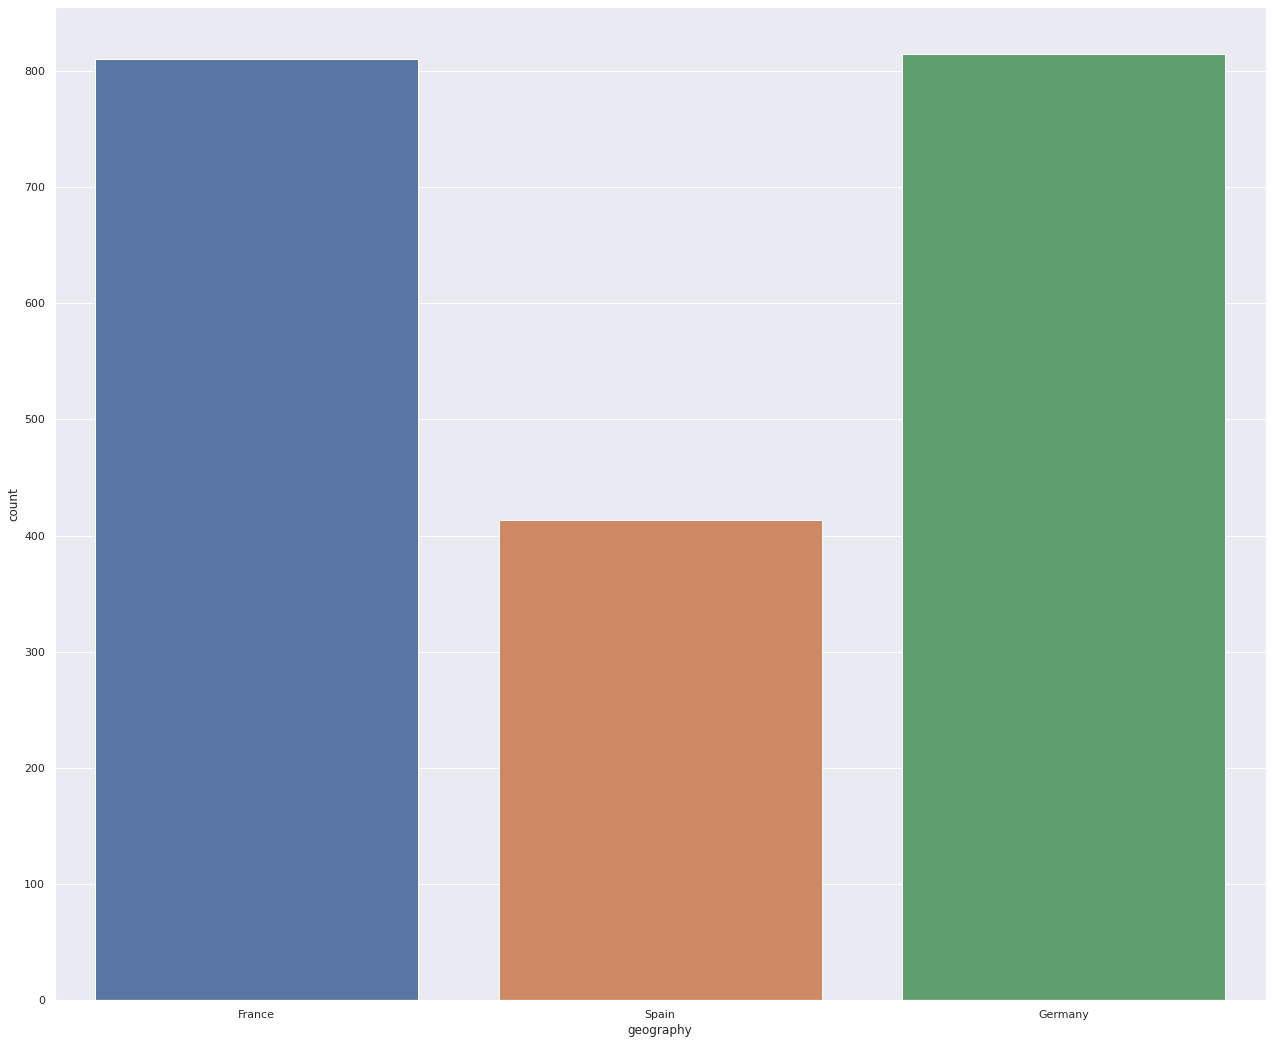

In [268]:
sns.countplot(x = 'geography', data = df_geo[df_geo['exited']==1]);

In [269]:
df_geo.groupby(['geography'])['exited'].value_counts(normalize = True ).to_frame(name = 'clients').reset_index()

,geography,exited,clients
0,France,0,0.838452
1,France,1,0.161548
2,Germany,0,0.675568
3,Germany,1,0.324432
4,Spain,0,0.833266
5,Spain,1,0.166734


In [270]:
df_geo.groupby(['exited'])['geography'].value_counts(normalize = True ).to_frame(name = 'clients').reset_index()

,exited,geography,clients
0,0,France,0.527942
1,0,Spain,0.259199
2,0,Germany,0.212859
3,1,Germany,0.399607
4,1,France,0.397644
5,1,Spain,0.202749


- Ao analisar clientes de cada pais foi visto que a taxa de churn de clientes residentes na Franca é de 16%, semelhante a Espanha, ja Alemanha possui uma taxa de 36% considerando o tamanho das populacoes. 
- Clientes em churn foi visto que 39% sao da Alemanha e Franca, 20% sao da Espanha. 
- Clientes que nao estao em chur, 52% sao franceses,25% espanhois e 21% alemaes.  

### H5. Clientes com salario menor que a media do pais tem Churn 10% maior. 
**FALSE** Clintes com Salario acima da mediana do pais estao 1% mais presentes em Churn que clientes que possuem salario menor que a mediana.

In [271]:
df_geo_salary = df4[['exited', 'geo_median_salary', 'estimated_salary']].copy()

In [272]:
df_geo_salary['above_below'] = df_geo_salary.apply(lambda x : 'above' if x['estimated_salary'] > x['geo_median_salary']
                                                   else 'below', axis = 1 )

In [273]:
# Porcentagem de clienetes acima e abaixo da media em Churn
aux1 = (df_geo_salary.groupby('exited' )['above_below'].value_counts(normalize = True)*100).to_frame(name = 'clients').reset_index()
aux1

,exited,above_below,clients
0,0,below,50.269999
1,0,above,49.730001
2,1,above,51.006382
3,1,below,48.993618


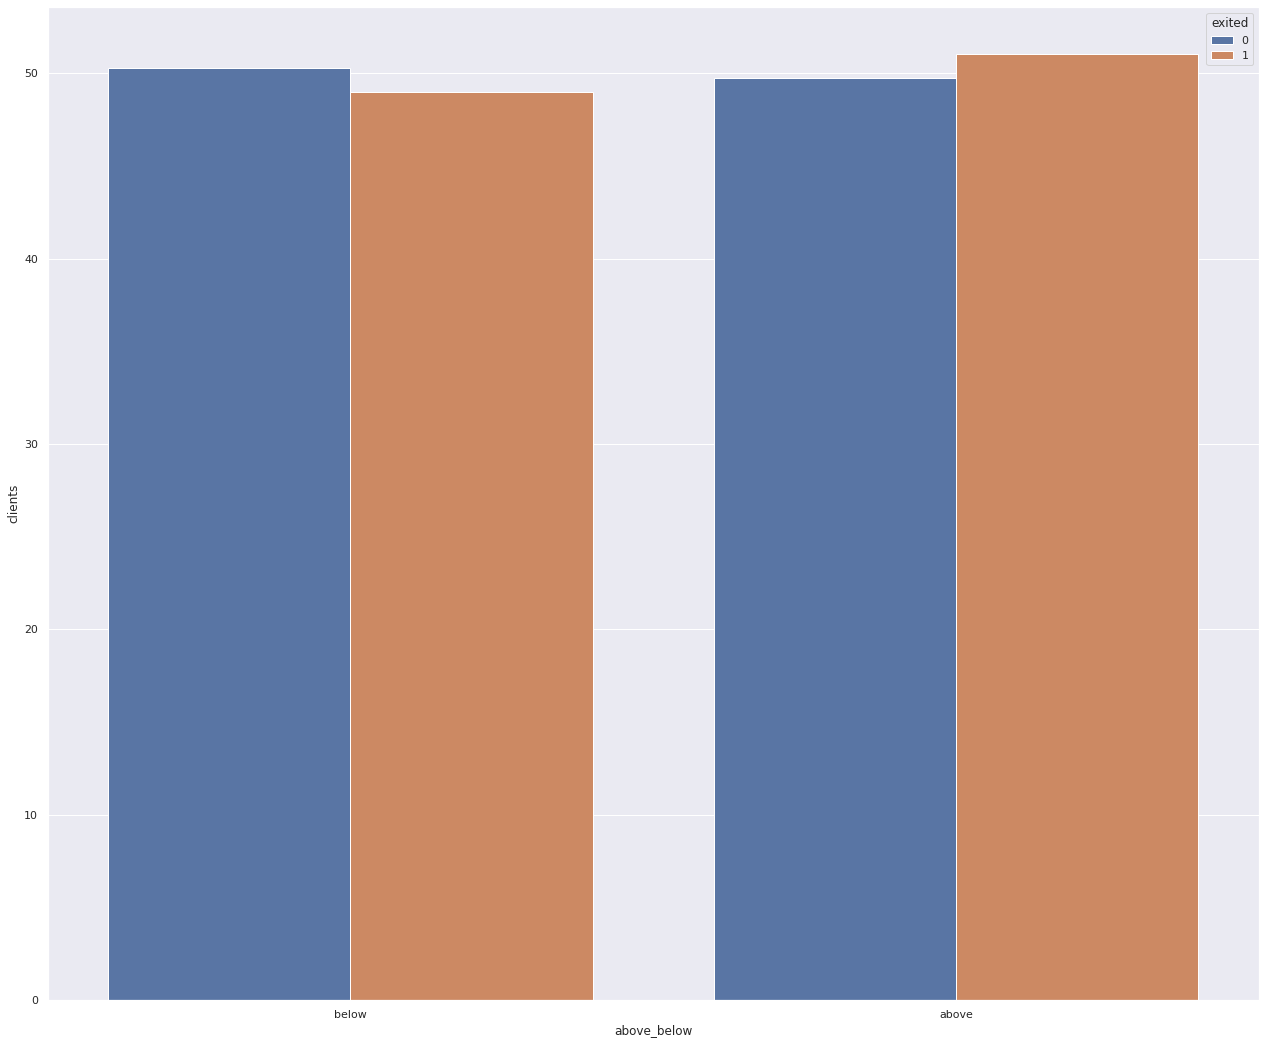

In [274]:
sns.barplot(x = 'above_below', y = 'clients', hue = 'exited', data = aux1);

In [275]:
# Porcentagem de clientes em churn e nao Churn que estao abaixo da media
df_geo_salary.groupby('above_below' )['exited'].value_counts(normalize = True).to_frame(name = 'clients')

clients
above_below exited          
above       0       0.792158
            1       0.207842
below       0       0.800440
            1       0.199560

### H6. Clientes com Credit Score menor que a media do pais tem Churn 10% maior. 
**TRUE** O Numero de clientes em Churn com credit score menor que a media de seu pais é 7% menor que clientes com credt score maior. 

In [276]:
df_geo_cred = df4[['exited', 'geo_median_cred', 'credit_score']].copy()

In [277]:
df_geo_cred['above_below'] = df_geo_cred.apply(lambda x : 'above' if x['credit_score'] > x['geo_median_cred']
                                                   else 'below', axis = 1 )

In [278]:
aux = (df_geo_cred.groupby('exited')['above_below'].value_counts()).to_frame(name = 'clients').reset_index()
aux

,exited,above_below,clients
0,0,above,4016
1,0,below,3947
2,1,below,1082
3,1,above,955


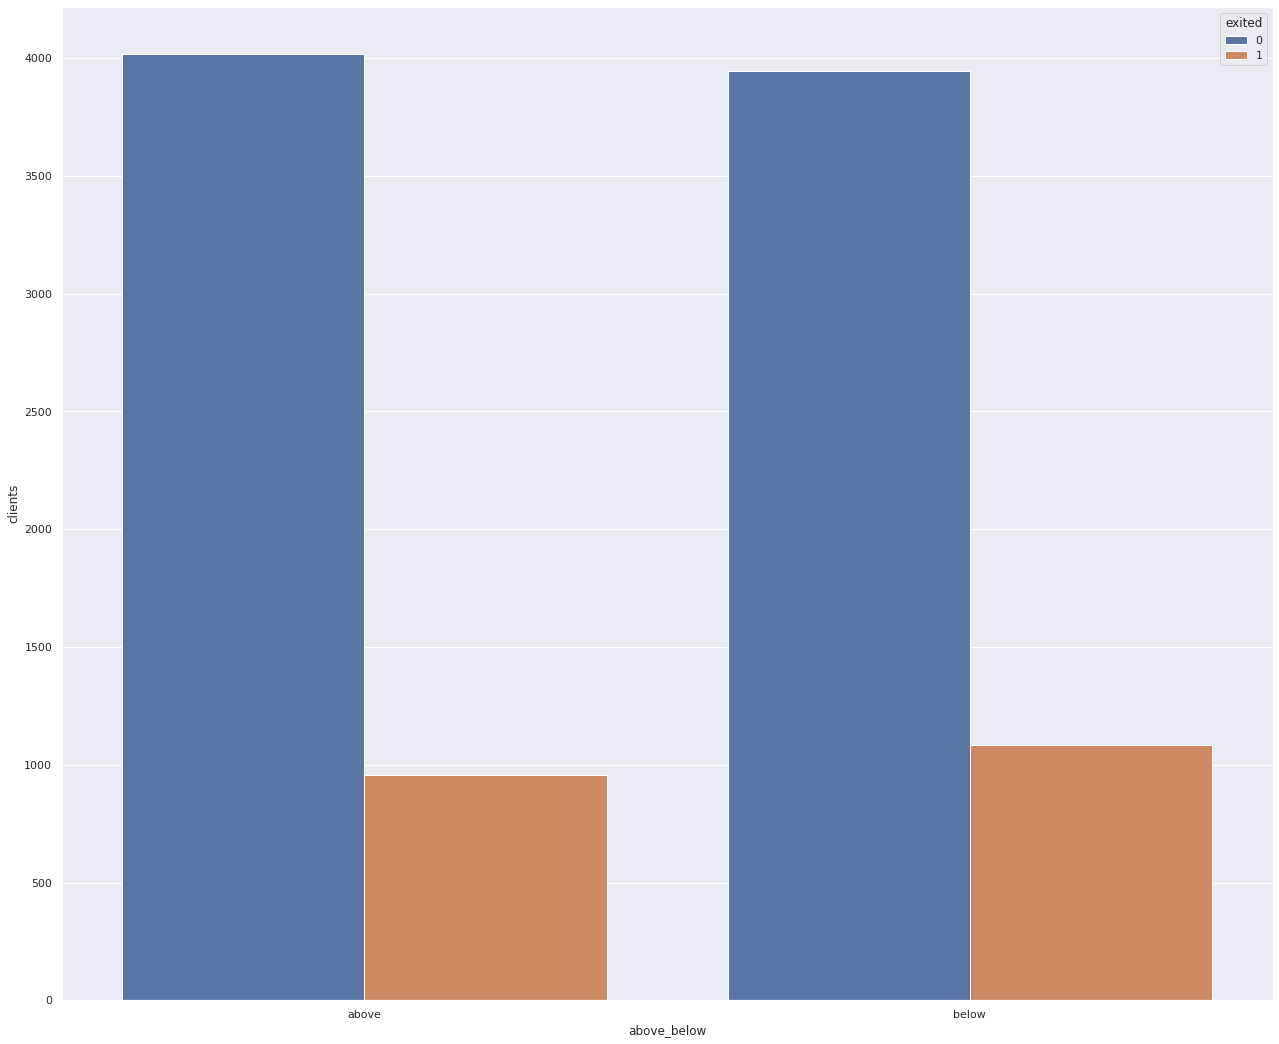

In [279]:
sns.barplot(x = 'above_below', y = 'clients', hue = 'exited', data = aux);

In [280]:
(df_geo_cred.groupby('above_below')['exited'].value_counts(normalize = True)*100).to_frame(name = 'clients').reset_index()

,above_below,exited,clients
0,above,0,80.788574
1,above,1,19.211426
2,below,0,78.484788
3,below,1,21.515212


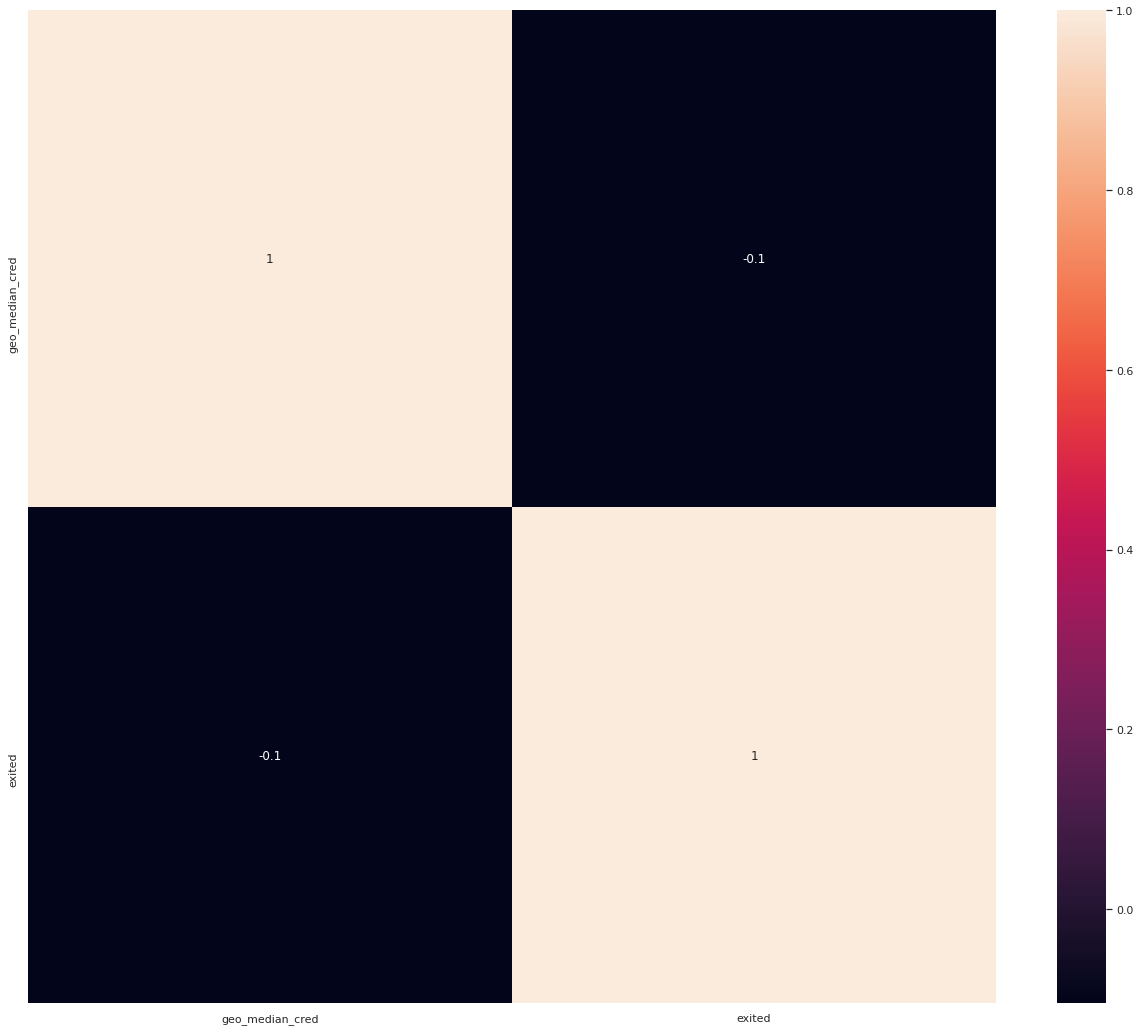

In [281]:
sns.heatmap(df_geo_cred[['geo_median_cred', 'exited']].corr(method ='pearson'), annot = True);

- Ao analisar o numero de clientes em churn foi encontrado que aproximadamente 53% desse numero e de clientes com a Credit Score menor que a mediana de seu pais e 46% maior. 
- Cerca de 49% dos clientes possuem Credit Score maior que a media do pais. 

### H7. Clientes com Saldo maior que a media do pais tem Churn  20% menor. 
**FALSE** Clientes com saldo maior que a media de seu pais são aproximadamente 5% mais presentes em Churn, se comparado com clientes com saldo menor. 

In [282]:
df_geo_balance = df4[['exited', 'geo_median_balc', 'balance']].copy()

In [283]:
df_geo_balance['below_above'] = df_geo_balance.apply(lambda x: 'above' if x['balance'] > x['geo_median_balc']
                                                    else 'below', axis = 1)

In [284]:
aux = df_geo_balance.groupby('exited')['below_above'].value_counts(normalize = True).to_frame(name = 'clients').reset_index()
aux

,exited,below_above,clients
0,0,below,0.506844
1,0,above,0.493156
2,1,above,0.526264
3,1,below,0.473736


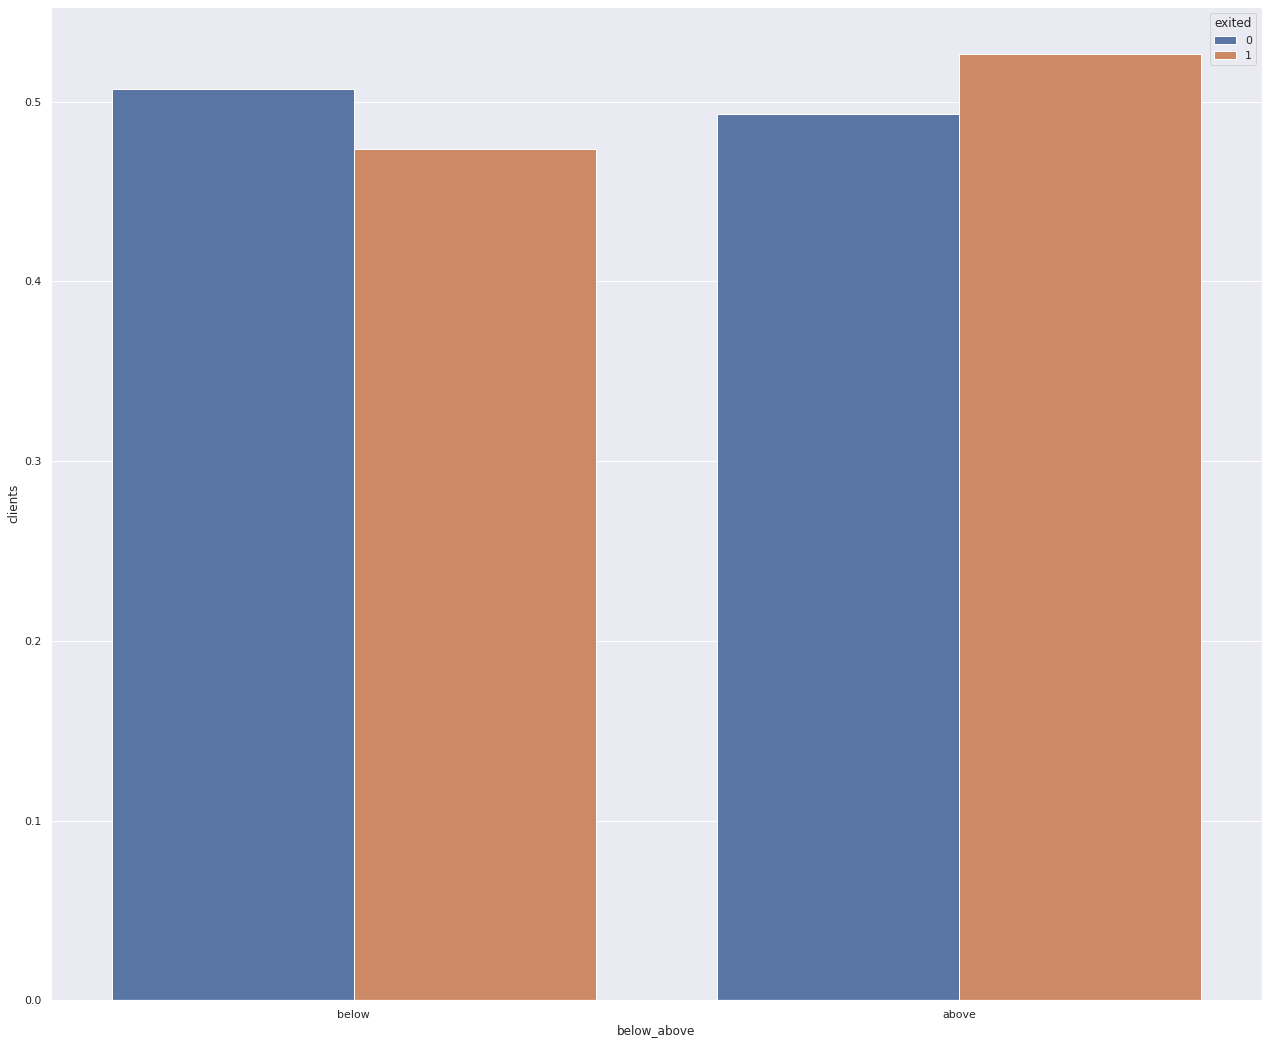

In [285]:
sns.barplot(x = 'below_above', y ='clients', hue = 'exited', data = aux);

In [286]:
aux1 = df_geo_balance.groupby('below_above')['exited'].value_counts(normalize = True).to_frame(name = 'clients').reset_index()
aux1

,below_above,exited,clients
0,above,0,0.785557
1,above,1,0.214443
2,below,0,0.807039
3,below,1,0.192961


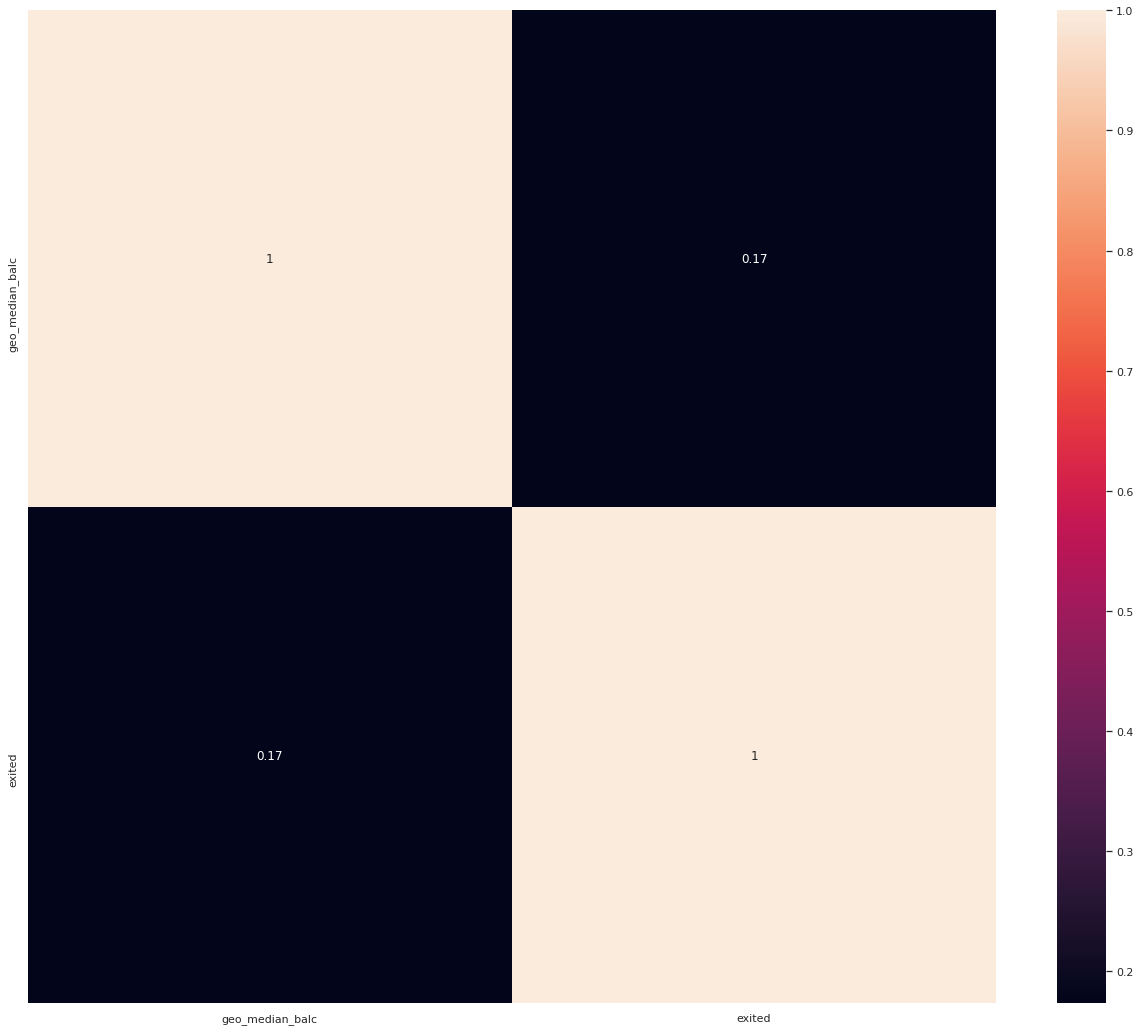

In [287]:
sns.heatmap(df_geo_balance[['geo_median_balc', 'exited']].corr(method ='pearson'), annot = True);

- Como analisado a populacao d clientes em churn, 52% dos clientes tem seu saldo maior que a media de seu pais, logo 47% tem abaixo. 
- Analisando a populacao de clientes com saldo acima da media, a taxa de Churn é aproximadamente 21%, 2% a mais que a taxa de Churn da populacao com saldo menor.

### H8. Churn é 10% menor para clientes que possuen cartão. 

In [288]:
df_cred = df4[['has_cr_card', 'exited']].copy()

In [289]:
df_cred['has_cr_card'].value_counts(normalize = True)

1    0.7055
0    0.2945
Name: has_cr_card, dtype: float64

In [290]:
aux = df_cred.groupby('exited')['has_cr_card'].value_counts(normalize = True).to_frame(name = 'clients').reset_index()
aux

,exited,has_cr_card,clients
0,0,1,0.707146
1,0,0,0.292854
2,1,1,0.699067
3,1,0,0.300933


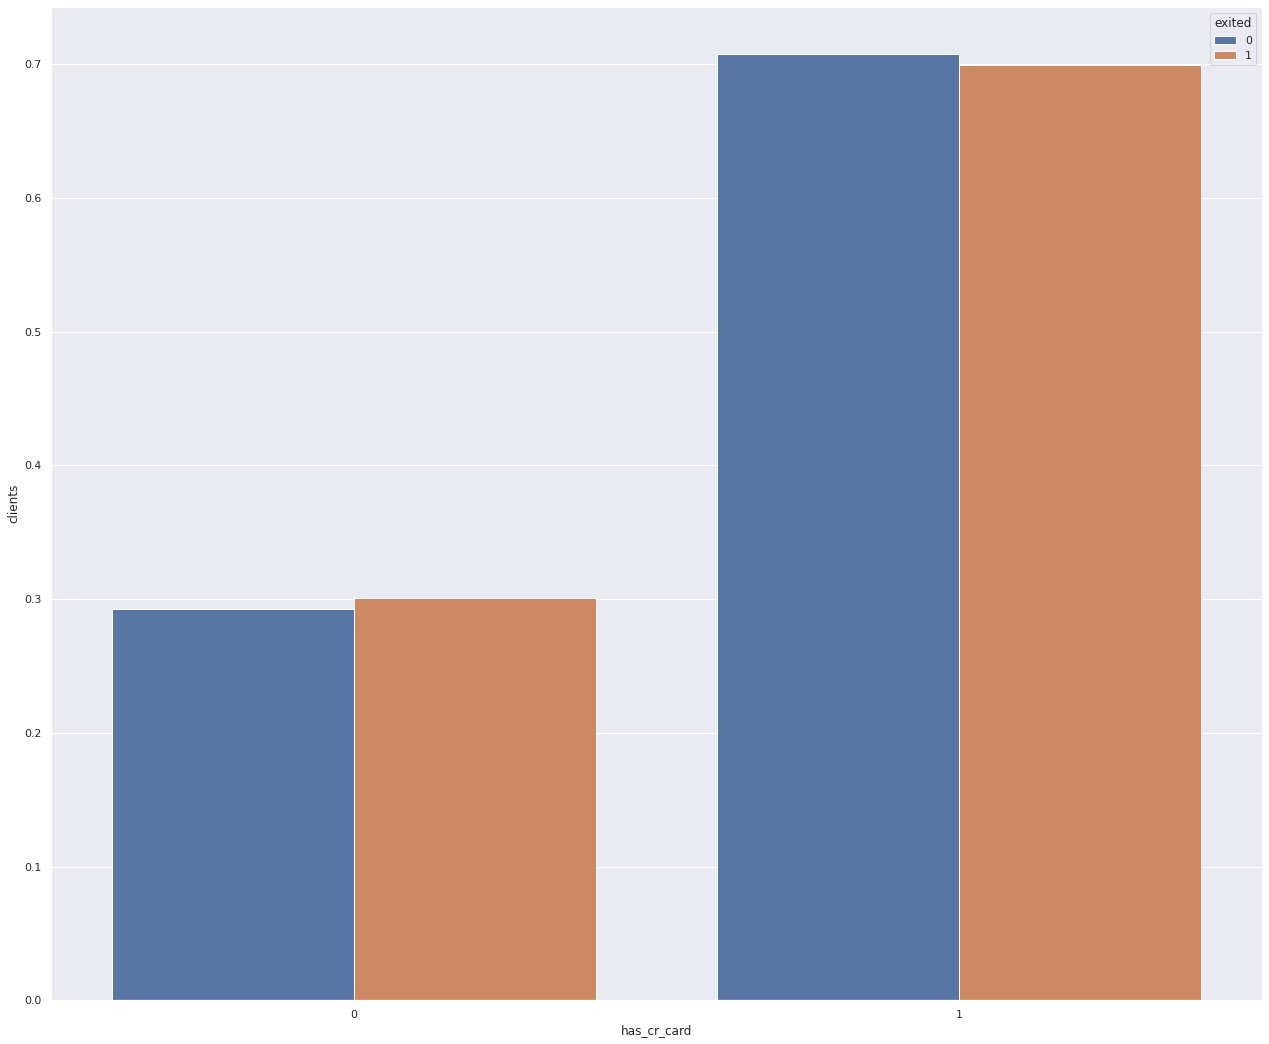

In [291]:
sns.barplot(x = 'has_cr_card', y = 'clients', hue = 'exited', data = aux);

In [292]:
aux1 = df_cred.groupby('has_cr_card')['exited'].value_counts(normalize = True).to_frame(name = 'clients').reset_index()
aux1

,has_cr_card,exited,clients
0,0,0,0.791851
1,0,1,0.208149
2,1,0,0.798157
3,1,1,0.201843


### H9. Churn é 30% menor para cliente ativos. 
**TRUE** Clientes não ativos estão mais presentes em Churn, embora não tenha um diferença de 30%, a porcentagem de 63% é consideravel para os parametros da Hipotese. 

In [293]:
df_active = df4[['exited', 'is_active_member']].copy()

In [294]:
# Porcentagem de clientes ativos e nao ativos na populacao
df_active['is_active_member'].value_counts(normalize = True)*100

1    51.51
0    48.49
Name: is_active_member, dtype: float64

In [295]:
aux = (df_active.groupby('exited')['is_active_member'].value_counts(normalize = True)*100).to_frame(name = 'clients').reset_index()
aux

,exited,is_active_member,clients
0,0,1,55.456486
1,0,0,44.543514
2,1,0,63.917526
3,1,1,36.082474


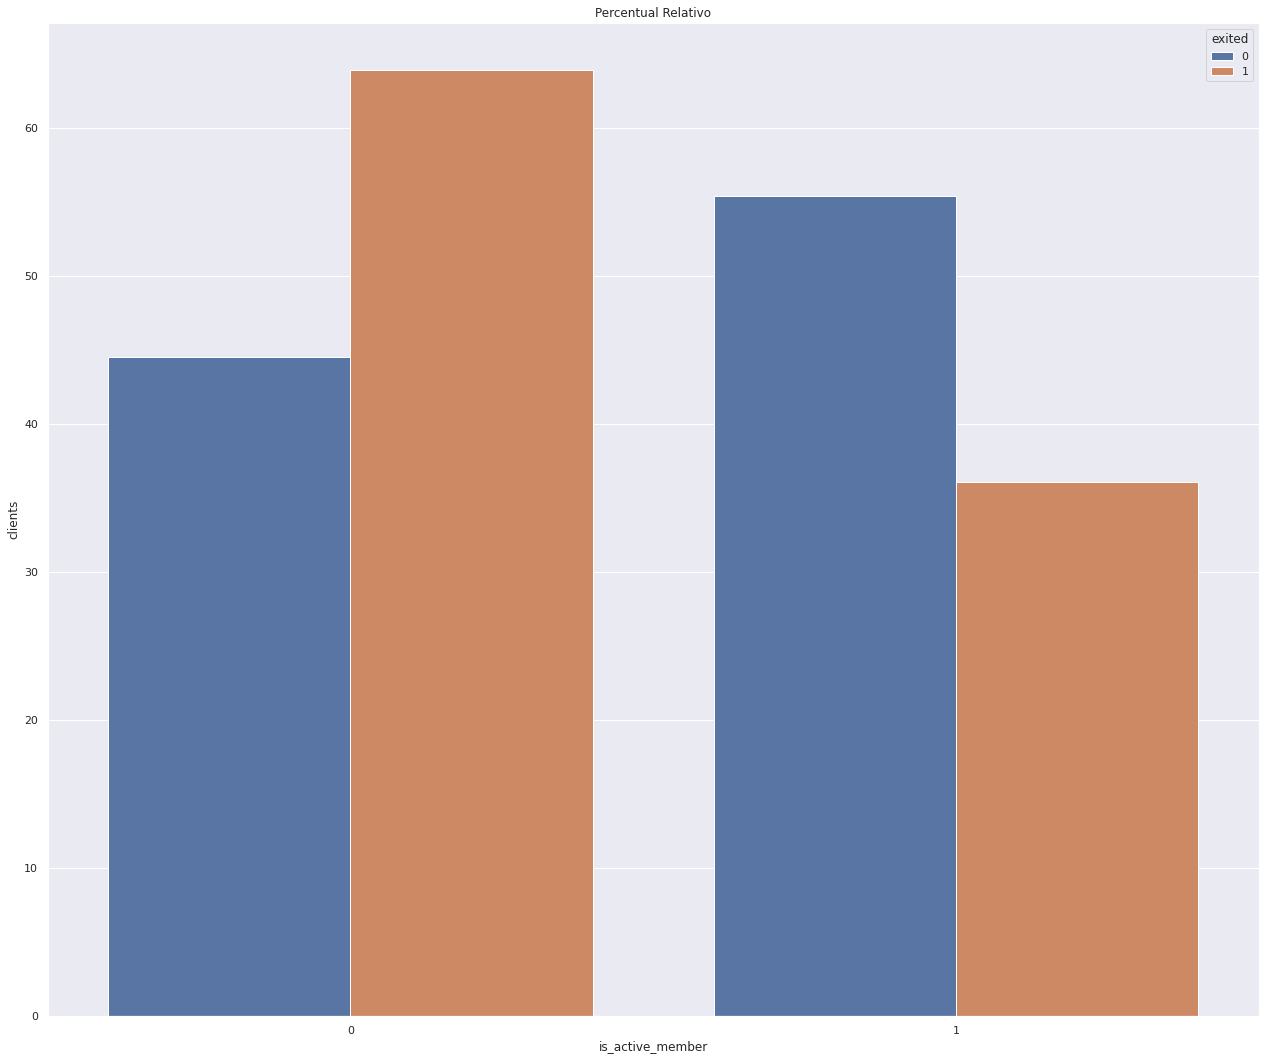

In [296]:
sns.barplot(x = 'is_active_member', y = 'clients', hue = 'exited', data = aux).\
set_title('Percentual Relativo');

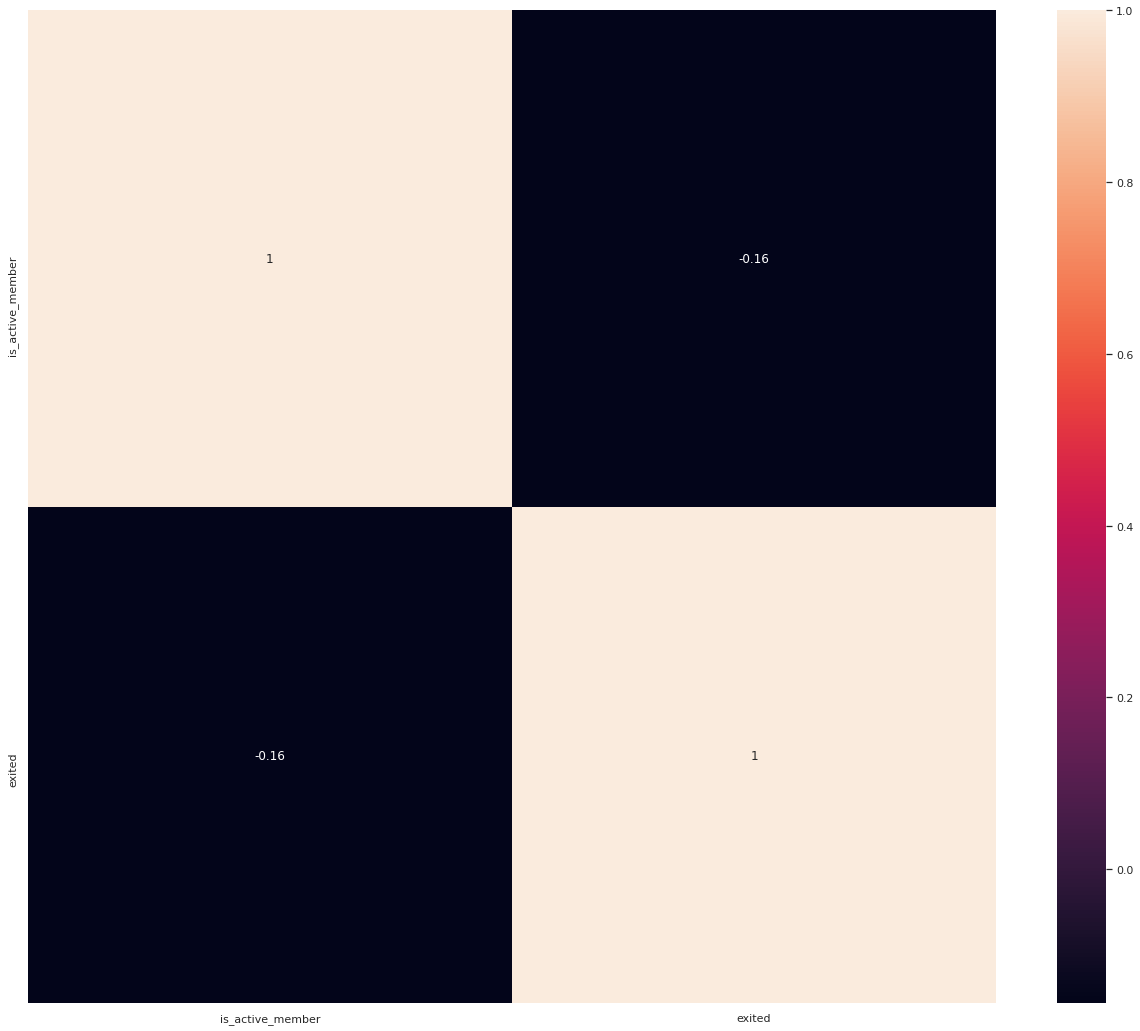

In [297]:
sns.heatmap(df_active[['is_active_member', 'exited']].corr(method ='pearson'), annot = True);

- Aproximadamente 51% dos clientes são ativos. 49% não são ativos. 
- Analisando os clientes em Churn, aproximadamente 64% são clientes não ativos, 36% são ativos
- Para os clientes que não estão em Churn, 55% deles são ativos e 45% não estão mais ativos. 

### H10. Churn é 25% maior para clientes com apenas um produto comprado. 
**TRUE** Clientes com apenas um produto comprado podem ser ate 60% mais presentes em Churn que clientes que compraram mais produtos. 

In [298]:
df_product = df4[['exited', 'num_of_products']].copy()

In [299]:
df_product['num_of_products'].value_counts(normalize = True)

1    0.5084
2    0.4590
3    0.0266
4    0.0060
Name: num_of_products, dtype: float64

In [300]:
aux = df_product['num_of_products'].value_counts().to_frame(name = 'client').reset_index()
aux

,index,client
0,1,5084
1,2,4590
2,3,266
3,4,60


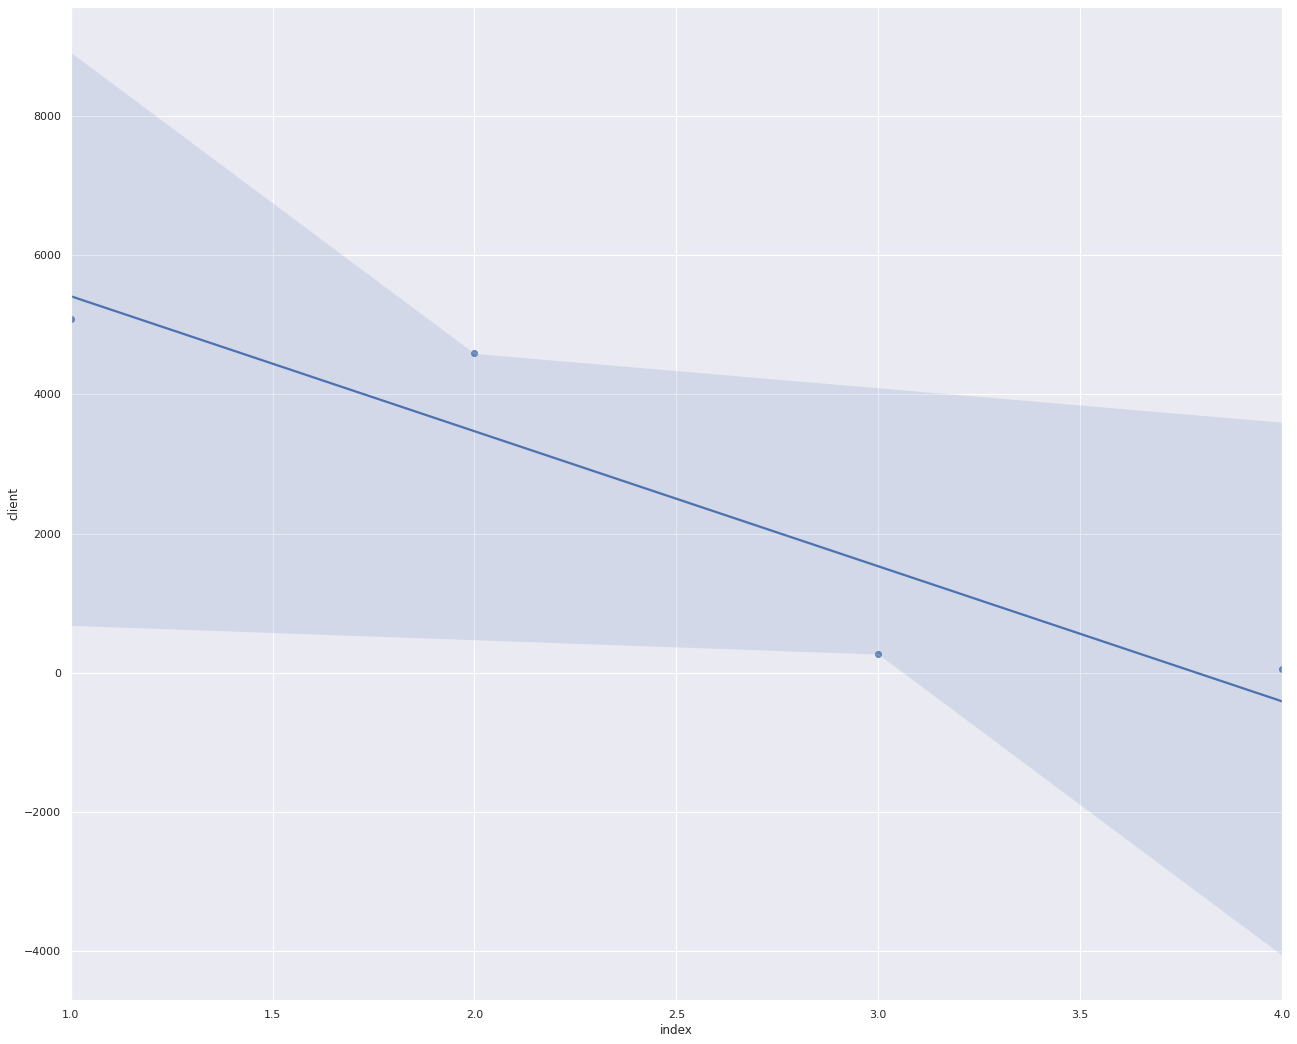

In [301]:
sns.regplot(x = 'index', y = 'client', data = aux);

In [302]:
aux1 = (df_product.groupby('exited')['num_of_products'].value_counts(normalize = True)*100).to_frame(name = 'client').reset_index()
aux1

,exited,num_of_products,client
0,0,2,53.271380
1,0,1,46.150948
2,0,3,0.577672
3,1,1,69.170349
4,1,2,17.083947
5,1,3,10.800196
6,1,4,2.945508


In [303]:
aux2 = (df_product.groupby('num_of_products')['exited'].value_counts(normalize = True)*100).to_frame(name = 'client').reset_index()
aux2

,num_of_products,exited,client
0,1,0,72.285602
1,1,1,27.714398
2,2,0,92.418301
3,2,1,7.581699
4,3,1,82.706767
5,3,0,17.293233
6,4,1,100.000000


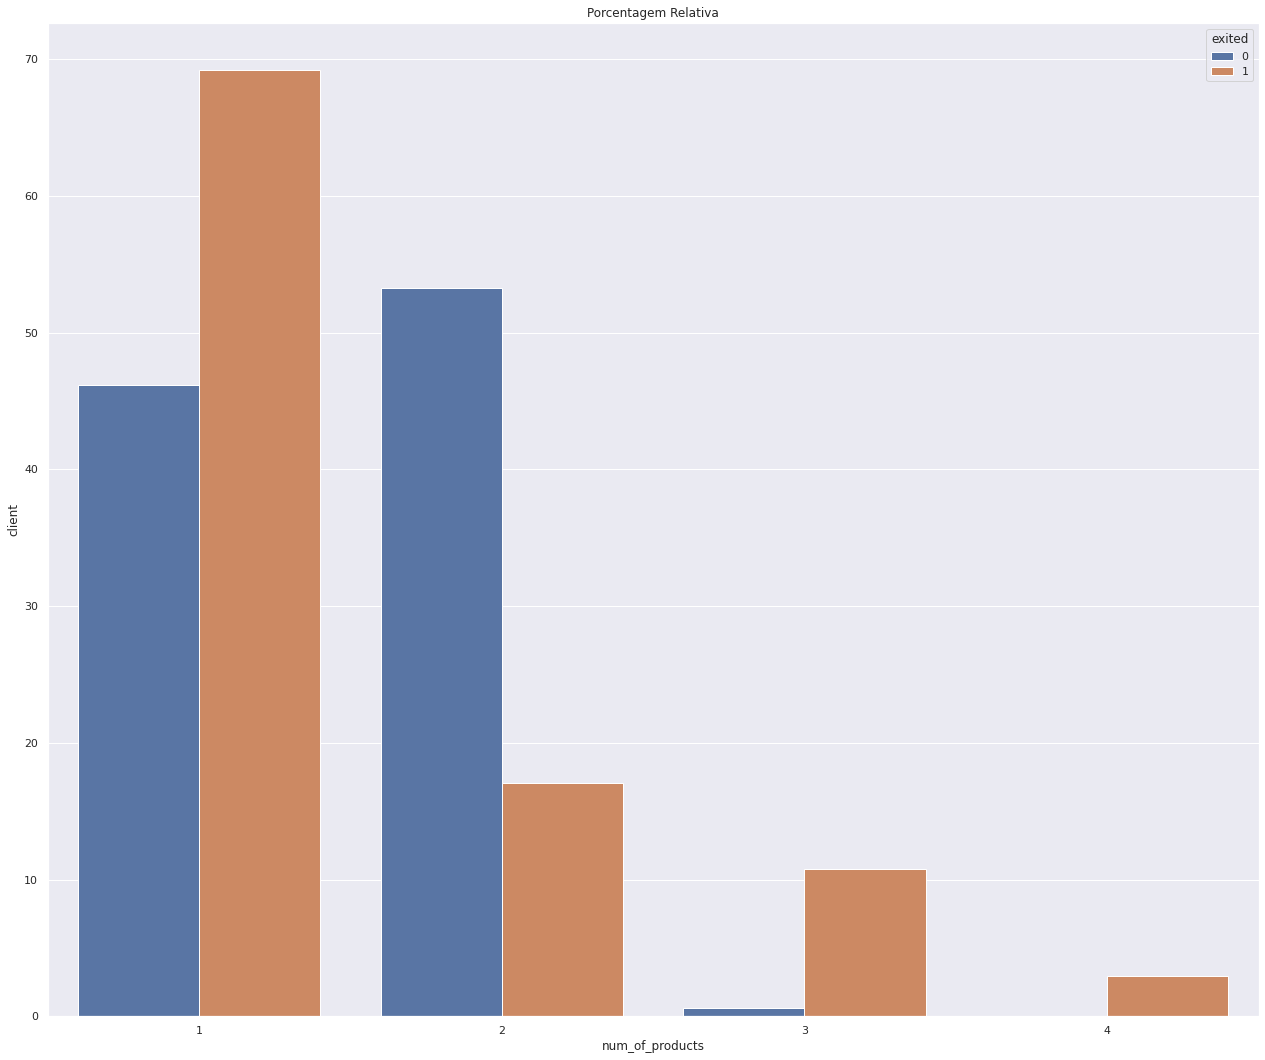

In [304]:
sns.barplot(x = 'num_of_products', y = 'client', hue = 'exited', data = aux1).set_title('Porcentagem Relativa');

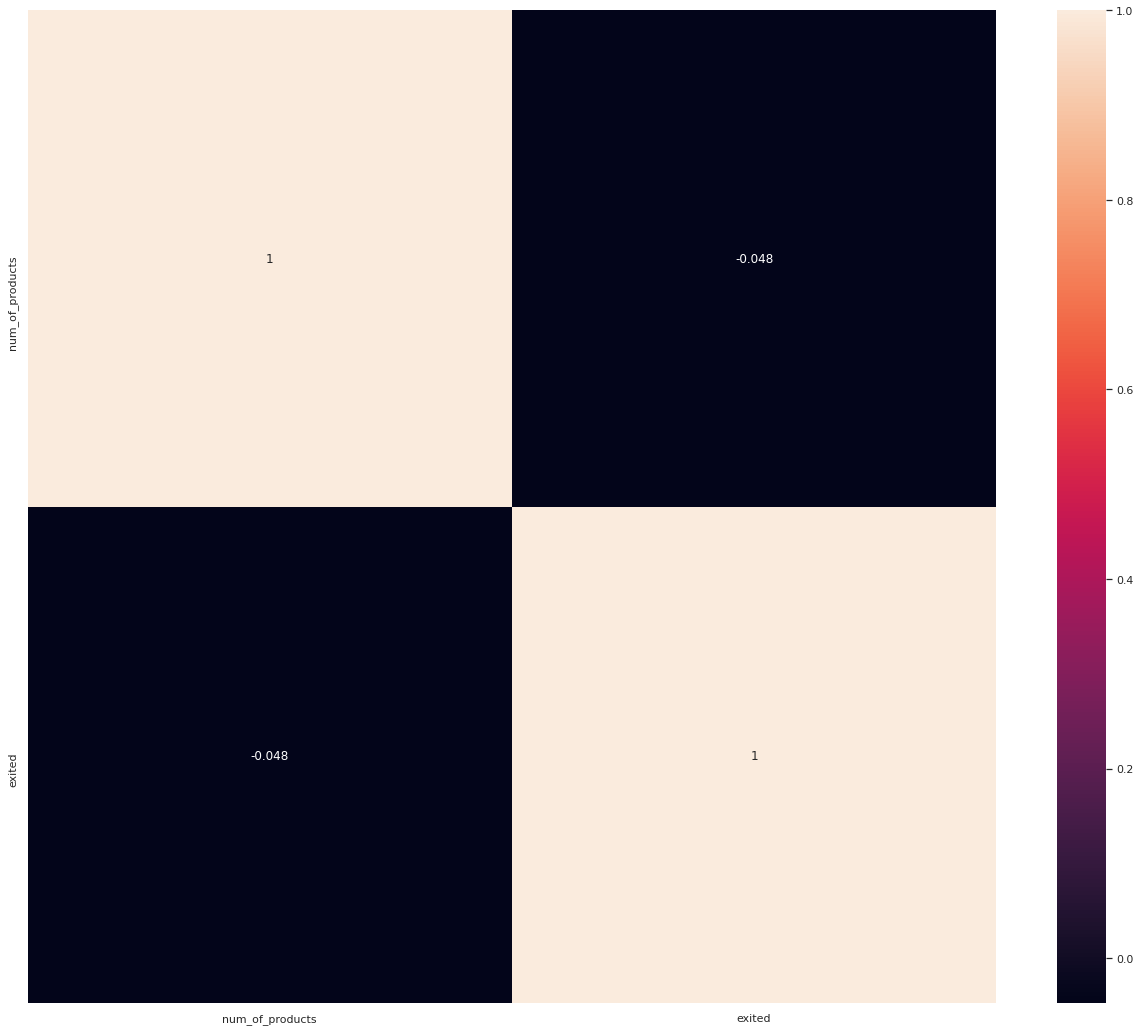

In [305]:
sns.heatmap(df_product[['num_of_products', 'exited']].corr(method ='pearson'), annot = True);

- 50% dos clientes possui apenas um produto. 
- 100% dos clientes com 4 produtos comprados estao em Churn
- Analisando os Clientes em Churn, aproximadamente 70% deles possuem apenas um produto comprado, enquanto 17% possuem 2 produtos, 10% possuem 3 e apenas 2% possuem 4
- Analisando clientes que nao estao em Churn 54% deles possuem 2 produtos, sendo assim a maioria. 
- Considerando todos os clientes com apenas 1 produtos 70% nao estao em Churn
- Considerando todos os clientes com apenas 2 produtos 90% nao estao em Churn
- Considerando todos os clientes com apenas 3 produtos 17% nao estao em Churn

## 7.3 Multivariate

### 7.3.1 Numerical Attributes

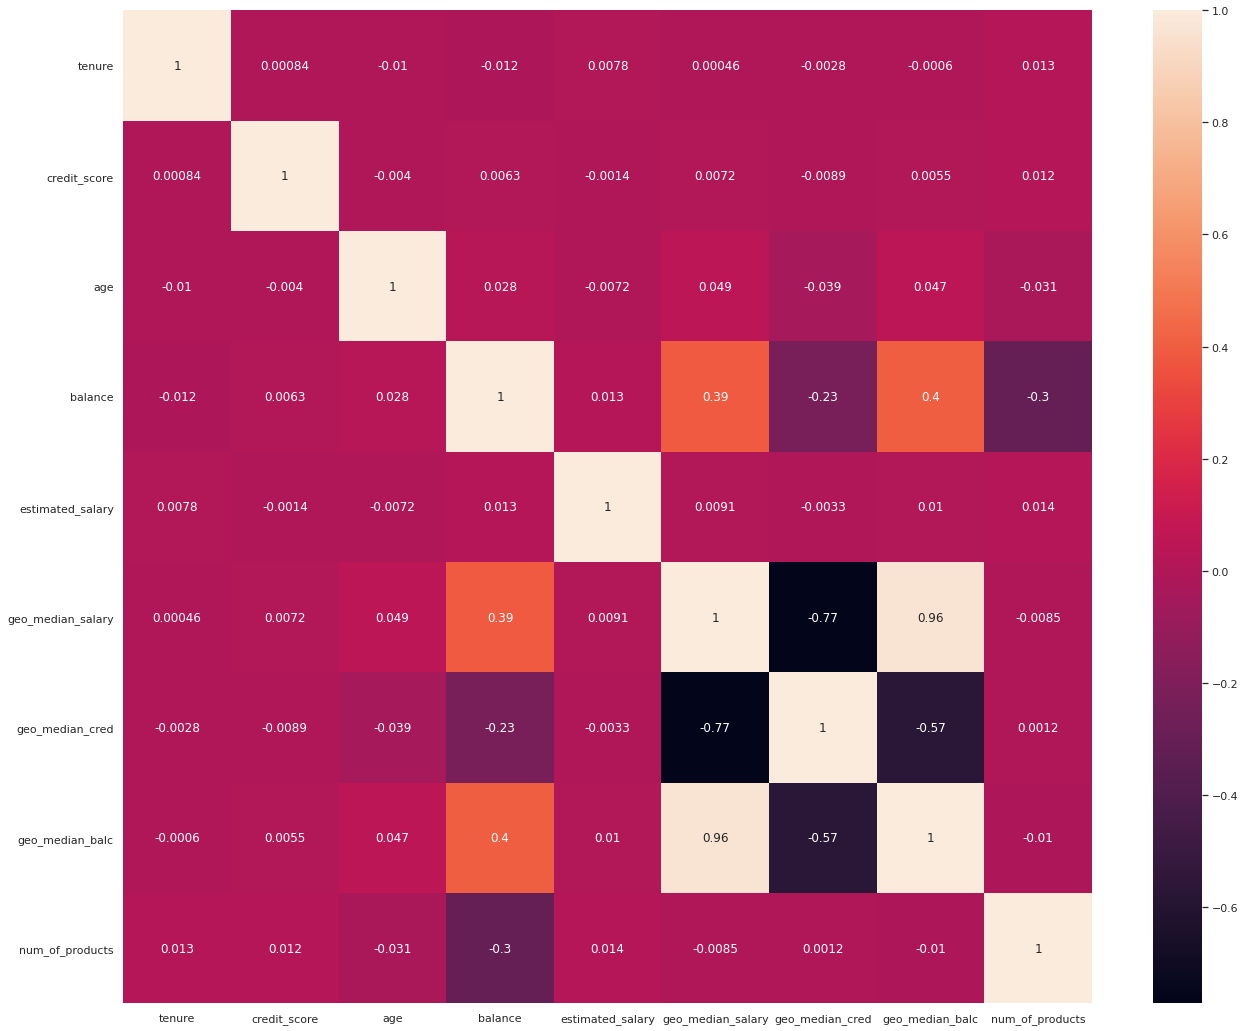

In [306]:
corr = df_num_attributes.corr(method = 'pearson')
sns.heatmap(corr , annot = True);
plt.yticks(rotation='horizontal');

### 7.3.1 Categorical Attributes

In [307]:
#apply cramers v correlation to all categorical attributes  

x_columns = df_cat_attributes.columns
y_columns = df_cat_attributes.columns

crame = {}

for x_col in x_columns:
    corr_list = []
    for y_col in y_columns:
        corr_list.append(cramer_v(df_cat_attributes.loc[:,x_col], df_cat_attributes.loc[:,y_col]))
        
    crame[x_col] = corr_list
    

In [308]:
# create df with cramers v correlation
df_cramer_corr = pd.DataFrame(crame)
df_cramer_corr = df_cramer_corr.set_index(x_columns)

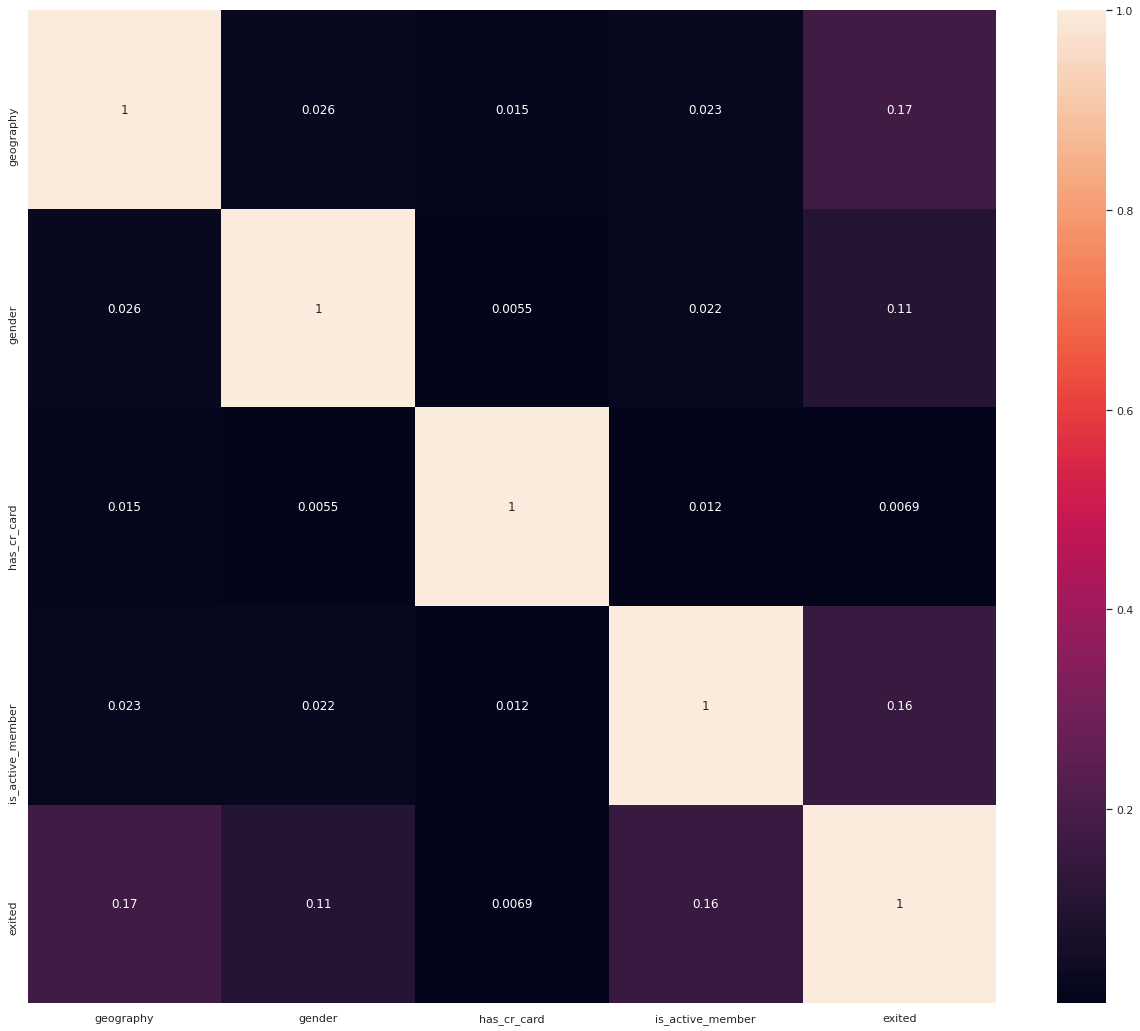

In [309]:
sns.heatmap(df_cramer_corr, annot = True);

# 8.0 Data Preparation

In [310]:
df5 = df4.copy()

## 8.1 Normalization 

### 8.1.1 Balance 

In [311]:
df5[['balance']].head(5)

,balance
0,0.00
1,83807.86
2,159660.80
3,0.00
4,125510.82


In [312]:
scaler_balance = StandardScaler()
df5['balance'] = scaler_balance.fit_transform(df5[['balance']].values)

In [325]:
df5[['balance', 'credit_score']].head(5)

,balance,credit_score
0,-1.225848,-0.326221
1,0.117350,-0.440036
2,1.333053,-1.536794
3,-1.225848,0.501521
4,0.785728,2.063884


### 8.1.1 Credit Score

In [314]:
df5[['credit_score']].head(5)

,credit_score
0,619
1,608
2,502
3,699
4,850


In [315]:
scaler_credit = StandardScaler()
df5['credit_score'] = scaler_credit.fit_transform(df5[['credit_score']].values)

In [316]:
df5[['credit_score']].head(5)

,credit_score
0,-0.326221
1,-0.440036
2,-1.536794
3,0.501521
4,2.063884


## 8.2 Rescaling 

In [317]:
df5[['tenure', 'age', 'estimated_salary', 'geo_median_salary',
     'geo_median_cred', 'geo_median_balc', 'num_of_products']].head(5)

,tenure,age,estimated_salary,geo_median_salary,geo_median_cred,geo_median_balc,num_of_products
0,2,42,101348.88,99132.31,653.0,62153.50,1
1,1,41,112542.58,99984.86,651.0,61710.44,1
2,8,42,113931.57,99132.31,653.0,62153.50,3
3,1,39,93826.63,99132.31,653.0,62153.50,2
4,2,43,79084.10,99984.86,651.0,61710.44,1


In [318]:
# min max scaler 
robust_scaler = MinMaxScaler()

# tenure 
df5['tenure'] = robust_scaler.fit_transform( df5[['tenure']].values)

#age 
df5['age'] = robust_scaler.fit_transform( df5[['age']].values)

# estimated salary
df5['estimated_salary'] = robust_scaler.fit_transform( df5[['estimated_salary']].values)

# geo_median_salary
df5['geo_median_salary'] = robust_scaler.fit_transform( df5[['geo_median_salary']].values)

# geo_median_cred
df5['geo_median_cred'] = robust_scaler.fit_transform( df5[['geo_median_cred']].values)

# geo_median_balc
df5['geo_median_balc'] = robust_scaler.fit_transform( df5[['geo_median_balc']].values)

In [319]:
df5[['tenure', 'age', 'estimated_salary', 'geo_median_salary',
     'geo_median_cred', 'geo_median_balc', 'num_of_products']].head(5)

,tenure,age,estimated_salary,geo_median_salary,geo_median_cred,geo_median_balc,num_of_products
0,0.2,0.324324,0.506735,0.000000,1.0,0.00764,1
1,0.1,0.310811,0.562709,0.261125,0.0,0.00000,1
2,0.8,0.324324,0.569654,0.000000,1.0,0.00764,3
3,0.1,0.283784,0.469120,0.000000,1.0,0.00764,2
4,0.2,0.337838,0.395400,0.261125,0.0,0.00000,1


In [320]:
# robust scaler 
min_max_scaler = MinMaxScaler()

# num_of_products
df5['num_of_products'] = min_max_scaler.fit_transform( df5[['num_of_products']].values)

In [321]:
df5[['tenure', 'age', 'estimated_salary', 'geo_median_salary',
     'geo_median_cred', 'geo_median_balc', 'num_of_products']].head(5)

,tenure,age,estimated_salary,geo_median_salary,geo_median_cred,geo_median_balc,num_of_products
0,0.2,0.324324,0.506735,0.000000,1.0,0.00764,0.000000
1,0.1,0.310811,0.562709,0.261125,0.0,0.00000,0.000000
2,0.8,0.324324,0.569654,0.000000,1.0,0.00764,0.666667
3,0.1,0.283784,0.469120,0.000000,1.0,0.00764,0.333333
4,0.2,0.337838,0.395400,0.261125,0.0,0.00000,0.000000


## 8.3 Transformation 

### 8.3.1 Enconding 

In [322]:
df5[['geography', 'gender']].head(10)

,geography,gender
0,France,Female
1,Spain,Female
2,France,Female
3,France,Female
4,Spain,Female
5,Spain,Male
6,France,Male
7,Germany,Female
8,France,Male
9,France,Male


In [323]:
# Label Enconding geography
label_enc = LabelEncoder()
df5['geography'] = label_enc.fit_transform(df5['geography'])

# Label Enconding gender
df5['gender'] = label_enc.fit_transform(df5['gender'])

In [324]:
df5[['geography', 'gender']].head(10)

,geography,gender
0,0,0
1,2,0
2,0,0
3,0,0
4,2,0
5,2,1
6,0,1
7,1,0
8,0,1
9,0,1
